# Project 3: Subreddit Classification
# Project Overview
**Data science process demonstrated:**
- [Problem Statement](#Problem-Statement)
- [Executive Summary](#Executive-Summary)
- [Web Scraping and Data Acquisition](#Web-Scraping-and-Data-Acquisition)
- [Data Inspect and Data Cleaning](#Data-Inspect-and-Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Preprocessing and Modeling](#Preprocessing-and-Modeling)
- [Modeling Evaluation](#Modeling-Evaluation)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

# Problem Statement

# Executive Summary

In [595]:
# Import libraries

# read files
# use os and glob to always select the latest json file
import glob 
import os

# Maths
import pandas as pd
import numpy as np

# Web scraping
import requests
import json
import time, warnings
import datetime as dt

# nlp, cleaning
import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string # for punctuation removal
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import nltk
from nltk.corpus import stopwords

# Modeling
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import roc_auc_score

# For visuals
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_venn as venn2
%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud

# display link
from IPython.core.display import display, HTML
from IPython.display import Image

# display data
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 500
pd.set_option('display.max_colwidth', None) # set full view to inspect text

# Web Scraping and Data Acquisition
Step 1: Quick data inspect to understand the steps of scraping using request and have a feel of all the data extracted from the subreddit. After reading up many ways to web scrap eg using psaw, praw, BeautifulSoup, pushshift_API, I decided to modify the function given during tutorial 4.06 Api Integration and Consumption instead.

**Summary of examining a request dataframe**
- Based on Readme, Reddit Api has a cap at 1,000 posts for each subreddit.
- Per request will return 25 posts. Hence I need to loop at least 40 times to obtain 1000 posts. 
- Examined which are the useful columns. 'title' is the most clean and good info. 'selftext' contains lots of useful content but less clean and lots of missing entries. Missing selftext is due author attached images or youtube videos instead of typing text.
- 'selftext' and 'selftext.html' are the same. Choose selftext.
- Decided not to extract comments since we have title that can supplement the insuficient selftext entries.
- 'name', 'id' could be the identity name of json file.
- 'author_fullname', 'author', address author's identity. Just need to choose 1 among these.
- 'up' and 'score' is the same. Choose 1 between them
- Ignore colours, look and feel related columns.
- Choose between 'created' or 'created_UTC' for date creation
- 'flair' tags did contain a low quantity amount of useful tags but it is either mainly flooded with emojis or its empty 
- Mostly of the data are 'None's in other columns
- 'distinguish' columns has very little entries, hence decided to abandon it
- Finally, I decided to scrap 'title', 'author', 'selftext', 'score', 'upvote_ratio', 'num_comments' and create a column on date

Step 2:
- create iterations to scrape 1000 posts, each 25 posts/request
- create a function to scrape the columns of interest
- extract json files
- convert to dataframe
- drop duplicates (Side note! During data cleaning, I had found out that there are duplicates hence i revert back to this step to add more iterations. By doing this, I found out that iterating more times does not give you more uniques, but more duplicates. Hence, i decided to implement drop duplicates in my functions so that directly I can know how many uniques I am having. I also choose 50 iterations instead of 40. This is to make sure I scrape as much as I can since I dont need to worry about duplicates, as there were removed directly during web scraping, in my function.)

Step 3: Apply function for both subreddits

Step 4: json file sanity check for both subreddits. I ensure there are 25 posts in last json file extracted by my web scraping fuction

Step 5: Output csv files for both subreddits

In [2]:
# Step 1: Brief inpection for 1 request. This is to plan out what function/method to extract all 1000 posts for each subreddit.

url = 'https://www.reddit.com/r/XboxSeriesX.json'
res = requests.get(url, headers={'User-agent': 'Pony Inc 1.0'})

# check for errors
if res.status_code != 200:
    print('Status error', res.status_code)

# Forming of a dictionary
reddit_dict = res.json()

# extract data
posts = [p['data'] for p in reddit_dict['data']['children']]

# form dataframe for easier reading
pd.DataFrame(posts).head(1)

approved_at_utc    subreddit  \
0            None  XboxSeriesX   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               selftext  \
0  &amp;#x200B;\n\nhttps://preview.redd.it/du20aqzqedp51.jpg?width=1920&amp;format=pjpg&amp;auto=webp&amp;s=db5193c62a37d86f6a72dbe5bf1db4f064bb32f1\n\nHey everybody,\n\nIn celebration of Bethesda joining the Xbox family, we’d like to take this opportunity to acknowledge the awesome communities that’ll be joining the Xbox family, too:\n\n* [r/BethesdaSoftworks](https://www.reddit.com/r/BethesdaSoftworks/): A fan-made community dedicated to all games, mods, and projects related to the game publisher Bethesda Softworks and its subsidiary developer studios.\n* [r/dishonored](https://www.reddit.com/r/dishonored/): Subreddit for the Arkane Studios video games Dishonored, Dishonored 2, and Dishonored: Death of the Outsider™.\n* [r/Doom](https://www.reddit.com/r/Doom/): Everything related to the hit action-horror series DOOM, by id software.\n* [r/ElderScrolls](https://www.reddit.com/r/ElderScrolls/): A community dedicated the Elder Scrolls franchise, developed by Bethesda Game Studios.\n* [r/elderscrollsonline](https://www.reddit.com/r/elderscrollsonline/): A Reddit community dedicated to The Elder Scrolls Online, an MMO developed by Zenimax Online.\n* [r/Fallout](https://www.reddit.com/r/Fallout/): A state-of-the-art su

In [3]:
# Step 2: modified from reddit-api workbook from 4.06 api integration and consumption lesson

def webscrape_subreddit(subreddit):
    
    posts = []
    after = None

    for a in range(50):
        
        url = f'https://www.reddit.com/r/{subreddit}/new.json' # download posts sorted by new
        
        if after == None:
            current_url = url
        else:
            current_url = url + '?after=' + after

        # send request to url
        res = requests.get(current_url, headers={'User-agent': 'Pony Inc 1.0'})

        # check for errors
        if res.status_code != 200:
            print('Status error', res.status_code)
            break
            
        # generate a random sleep duration to look more 'natural'
        sleep_duration = np.random.randint(2,6)
        time.sleep(sleep_duration)
    
        # get posts and add to [posts]
        current_dict = res.json()
        current_posts = [p['data'] for p in current_dict['data']['children']]
        posts.extend(current_posts)
        
        # Output JSON file for each request. Use timestamp to separate each request file 
        timestamp = dt.datetime.now()
        timestamp = timestamp.strftime(" %Y_%m_%d %H_%M_%S")
        with open(f'../json_files/{subreddit}/posts_{subreddit}_{timestamp}.json', 'w') as outfile:
            json.dump(current_dict, outfile)

        # get tag of last post on the page
        after = current_dict['data']['after']

        
    # create dataframe to extract useful columns

    df_post = pd.DataFrame(posts)
    df_post = df_post[['title','author','created', 'selftext', 'score', 'upvote_ratio', 'num_comments']]
    df_post['date_created'] = pd.to_datetime(df_post['created'], unit = 's') #create new date column
    # remove column that is used to create date
    df_post = df_post[['title','author','selftext', 'score', 'upvote_ratio', 'num_comments', 'date_created']]

    # check whether all posts are added to df_post
    df_post.shape[0] == len(posts)

    # Investigate duplicates
    print("There are", df_post.duplicated(subset='title').sum(), "number of duplicate posts")
    df_post = df_post.drop_duplicates(subset='title') #drop the duplicates

    # print number of posts saved
    print(f'After removing the duplicates, a total of {len(df_post)} posts were downloaded.')

    return df_post

In [4]:
%%time
# Step 3: Call function for XboxSeriesX dataframe
df_xboxseriesx = webscrape_subreddit('XboxSeriesX')
df_xboxseriesx.head()

There are 250 number of duplicate posts
After removing the duplicates, a total of 982 posts were downloaded.
Wall time: 3min 46s


title  \
0                                                Can we stop posting Taco Bell winner pictures?   
1                                                                        Quality HDMI switcher?   
2                                                                          Why can't MS buy EA?   
3  My biggest hope for next gen is finally giving us console plebs an FoV slider for every game   
4                 Looks like the share button will be fully mappable (Source-Xbox One settings)   

               author  \
0        thefeelgood2   
1  Weekend-At-Bernies   
2          infinitesd   
3           xDefimate   
4           mikey_stv   

                                                                                                                                                                                                                                                                                                                                                                                                             selftext  \
0                                                                                                                                                                                                                                                                                                                                                Seems like half the sub is just pictures of their Taco Bell email...   
1  I have a 1080p 144hz monitor and a 4K 60 monitor. I am going to be switching between the two depending on the type of game I play (MP / Campaign) \n\nMy question is if anyone knows a quality HDMI switcher? I’ve used a couple before and they’ve given me various issues. I’ve tried looking it up and haven’t been able to find any conclusive info on what to get. \n\nAny help would be appreciated, thanks!   
2                                                                                                                                                                                                                                                                                                                                                         Mass Effect Legendary edition is taking forever to release!   
3                                                                                                                              Please for the love of god please let us have the ability change the FoV in any game. There is no reason now not to have it. The series x is has more than enough power for this to work. \n\nI hope we get to see some of the settings series x games will have before it’s released.   
4                                                                                                                                                                                                                                                                                                                                                                                                                       

   score  upvote_ratio  num_comments        date_created  
0      3          1.00             1 2020-09-28 19:11:53  
1      1          1.00             7 2020-09-28 18:50:00  
2      0          0.20             9 2020-09-28 18:29:45  
3      2          0.67             5 2020-09-28 18:28:55  
4      6          0.88             5 2020-09-28 18:26:30

In [5]:
%%time
# Step 3: Call function for PS5 dataframe
df_ps5 = webscrape_subreddit('PS5')
df_ps5.head()

There are 301 number of duplicate posts
After removing the duplicates, a total of 931 posts were downloaded.
Wall time: 3min 30s


title  \
0                                       How PS5 and HDD storage should work in my opinion   
1                                  Why I think we'll see more 1st Party MP with next gen.   
2  What Spiderman movies to watch before jumping into Spiderman and Miles Morales on PS5?   
3                                                                  God Of War Remastered?   
4                       Seems like Sony’s collaboration with AMD may have been successful   

                 author  \
0               Emp0ri0   
1               kasual7   
2               Emp0ri0   
3  Vipor_Death_Blade007   
4              Aclysmic   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                selftext  \
0  It should have system where you basically storage all the games you like in external HDD ( PS4 and PS5)\n\nThe system opens up a list of games storaged on HDD and from that list you can *"open" and "close"* games, by *"opening"* a game it will move the game to PS5 storage keep it there until *"closed". S*o you can keep 800gb worth of games *"opened"* at the same time.  \n\n\nWhen you *"close"*  the game it transfer everything back to hdd so all the things to the smallest, like settings and what not will be transferred as if they would now on external hdd.  \n\n\nIt could be made easy enought for regular persons so they dont need to think so much about gigabytes, they just see what games they have on hdd, what games is already opened, and what games are grayed out from external since there is currently no enought space to open large game untill something is closed.   \n\n\nOpening will take some time based on a game, but it will be better than downloading a game from PSN every time.\n\nI know that this is basically what it already is with internal and external hdds and moving games between them, but this system is more userfriendly, main user oriented and cleaner  \n\n\nWhat come to PS4 games, you should maybe have an option to eather start a game from external hdd and be limited by that speed or *"open"* the game to your ps5 external first and gain better loading times. This would be very usefull, if you would want to randomly just hop on some old game for couple hours   
1                                                                                                                   With the anticipation for the TLOU MP I couldn't help but remembering 2yrs ago [Shawn Layden suggesting how much they will now invest in first party multiplayer titles](http://gametyrant.com/news/shawn-layden-wants-more-first-party-multiplayer-ga

In [6]:
# step 4: json sanity check to make sure no missing data for XboxSeries
# use os and glob to always select the latest json file to pull for sanity check
# this is to facilitate importing of json files named by timestamp, after multiple runs

list_of_files = glob.glob('../json_files/xboxseriesx/*.json') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)

# load a json file using open(), json.load(). Check the number of posts in 1 request
f = open(latest_file,)
# returns JSON object as a dictionary 
json_xboxseriesx = json.load(f)
print("Sanity check shows the latest request containing", len(json_xboxseriesx['data']['children']), "posts")

Sanity check shows the latest request containing 25 posts


In [7]:
# step 4: json sanity check to make sure no missing data for PS5
# use import os and import glob to always select the latest json file to pull for sanity check
# this is to facilitate importing of json files named by timestamp, after multiple runs

list_of_files = glob.glob('../json_files/ps5/*.json') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)

# load a json file using open(), json.load(). Check the number of posts in 1 request
f = open(latest_file,)

# returns JSON object as a dictionary 
json_ps5 = json.load(f)
print("Sanity check shows the latest request containing", len(json_ps5['data']['children']), "posts")

Sanity check shows the latest request containing 25 posts


In [8]:
# step 5: output XboxSeriesX and PS5 dataframe posts to csv
df_xboxseriesx.to_csv('../data/xboxseriesx_posts1.csv', index = False)
df_ps5.to_csv('../data/ps5_posts1.csv', index = False)

# Data Inspect and Data Cleaning
## Data Import
I make a copy of the csv files created in the web scraping step. So that I only load the same files for analysis after this point. This is to ensure everytime I have to re-run this entire report, my analysis wasnt overwritten and I have consistent data for later analysis. This is to ensure:\
1) any new posts into subreddit\
2) when someone delete a post\
3) when a comment is added\
4) new upvote scoring\
generated when I re-run this entire report, will not affect my existing analysis.

Loading a csv at this point also help to save time as I dont need to spend time to run web scraping when resetting my analysis. I can just load the data from this step onwards for analysis if resetting is needed.

In [472]:
# load csvs so that i dont need to rerun webscraping everytime i need to reset my code.
# Notice that the files are of different names as my output csv at web scraping step. This is to ensure consist data
df_xboxseriesx = pd.read_csv('../data/xboxseriesx_posts.csv')
df_ps5 = pd.read_csv('../data/ps5_posts.csv')

## Data Inspect

In [473]:
print("There are", len(df_xboxseriesx), "XboxSeriesX posts")
print("There are", df_xboxseriesx.shape[1], "columns in XboxSeriesX posts")
print("There are", len(df_ps5), "PS5 posts")
print("There are", df_ps5.shape[1], "columns in PS5 posts")
print("The number of rows for both subreddits is considerably near.\
 There shall not be any unbalance classification issue during modeling")

There are 976 XboxSeriesX posts
There are 7 columns in XboxSeriesX posts
There are 930 PS5 posts
There are 7 columns in PS5 posts
The number of rows for both subreddits is considerably near. There shall not be any unbalance classification issue during modeling


In [474]:
df_xboxseriesx.info()
# selftext has most NaN. Which is 30%. 
# all datatypes are correct but we need to change all texts to string so we can process the text data later

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         976 non-null    object 
 1   author        976 non-null    object 
 2   selftext      683 non-null    object 
 3   score         976 non-null    int64  
 4   upvote_ratio  976 non-null    float64
 5   num_comments  976 non-null    int64  
 6   date_created  976 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 53.5+ KB


In [475]:
df_ps5.info()
# selftext has most NaN. Which is 23.5%. 
# all datatypes are correct but we need to change all texts to string so we can process the text data later

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         930 non-null    object 
 1   author        930 non-null    object 
 2   selftext      711 non-null    object 
 3   score         930 non-null    int64  
 4   upvote_ratio  930 non-null    float64
 5   num_comments  930 non-null    int64  
 6   date_created  930 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 51.0+ KB


**We see selftext have many missing entries. This is probably because not all posts on reddit have body text (i.e. they just have titles and links). Later we need to clear this null value issue so that we can analyse the dataframe. % null selftext difference between the 2 subreddit is 6.5%. Meaning there is no major difference in posting behaviour of selftext, for both subreddits**

There are more text posts under PS5 subreddit. 6.47% More people post text under r/PS5


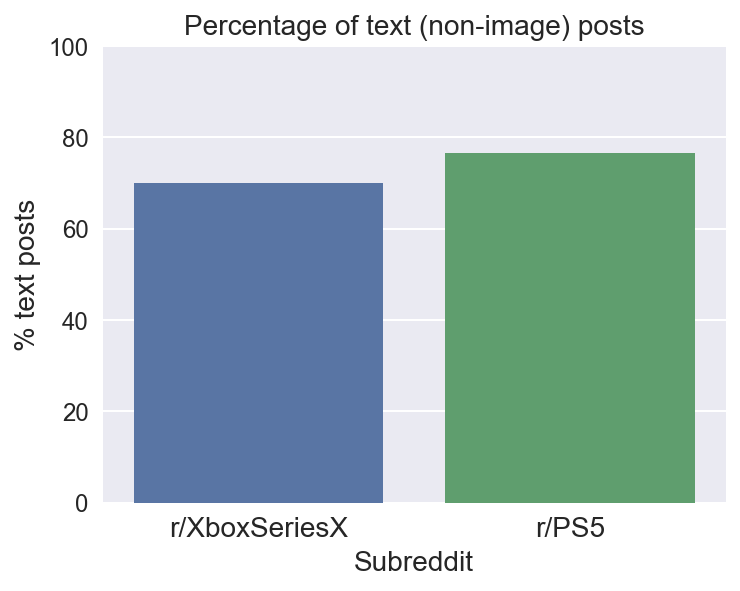

In [476]:
df_xboxseriesx_text_posts = (df_xboxseriesx.notnull().sum()['selftext']/df_xboxseriesx.shape[0]) * 100
df_ps5_text_posts = (df_ps5.notnull().sum()['selftext']/df_ps5.shape[0]) * 100

print(f"There are slightly more text posts under PS5 subreddit. \
{round((df_ps5_text_posts - df_xboxseriesx_text_posts),2)}% More people post text under r/PS5")

plt.figure(figsize = (5,4))
sns.barplot(y = [df_xboxseriesx_text_posts, df_ps5_text_posts], x = ['r/XboxSeriesX','r/PS5'])
plt.title('Percentage of text (non-image) posts', fontsize=14)
plt.ylim(0,100)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.xlabel("Subreddit", fontsize=14)
plt.ylabel("% text posts", fontsize=14);

In [477]:
# inspect text eg title and selftext columns
df_xboxseriesx.head(50)
# need to further clean title and selftext to remove emoji, &amp, \n, ~, hyperlinks, #x200B

title  \
0                                                                                                                            "Random" fan decided to make this awesome XGP trailer. Credit to : Vincenzo Fayez channel   
1                                                                                                                                                                       Is the taco bell deal available in my country?   
2                                                                                                                                                                State of mouse and keyboard support on Xbox consoles?   
3                                                                                                 I don't know if anyone has posted this yet, but Amazon has the release date for Halo Infinite as December 31st, 2021   
4                                                                                                                                                                                          TV upgrade for the Series X   
5                                                                                                                     Does anyone know if xbox one controller battery packs will work in the new Series x controllers?   
6                                                                                                                                                                                How is this for a budget HDMI 2.1 T.V   
7                                                                                                                                                    Switching to console after 8 years of pc gaming with GOD tier PCs   
8                                                                                                                         I really like that you can add games to play later on the GP app even without a subscription   
9                                                                                                                                                                                            USB 7.1 surround support?   
10                                                                                                                                                                         Does it ship on the 10th or arrive by then?   
11                                                                                                                          Bought an Xbox One X instead of an Xbox Series X? You probably only have yourself to blame   
12                                                                                                                                                  i need something like this for the series x i preordered any link?   
13                                                                                                                                                                          Will Warzone on series X have fov slider ?   
14                                                                                                                                                                          Beyond Light free to Game Pass subscribers   
15  OMG I won the Xbox. I seriously can't believe it. I bought like over $40 in medium drinks and been waking up at 3am entering codes thinking I'll never win... and i won on my 2nd to last cup. I'm still in shock!   
16                                                                                                                                                                                         Godfall. Yeah, not for you.   
17                                                                                                                                                                             New to Xbox this new gen, what to play?   
18                                                                 

In [478]:
# inspect text eg title and selftext columns
df_ps5.head(50)
# need to remove emoji, &amp, \n, ~, hyperlinks, #x200B

title  \
0                                                                                                                                                      We have to stop   
1                                                                                                                                            PlayStation design studio   
2                                                                                                                      Will i be able to download my ps4 games on ps5?   
3                                                                                   Can we connect my PS4’s extended storage (hard drive) to PS5 and access the games?   
4                                                                                                                                 PlayStation plus collection question   
5                                                                                                          It’s time for PlayStation Studios to try new things for PS5   
6                                                                                                                    Question about 3 PS5 systems and account sharing.   
7                                                                                                                               Which Headset are you Guys Going With?   
8                                                                                                                           I'm just as excited for the 4K Uhd player.   
9                                                  Will the current PSVR Headset improve with the PS5 and will we finally be able to get longer cables for the camera?   
10                                                                                                                                          will black ps5 be a thing?   
11                                                                                                                Has anyone else forgotten that October even existed?   
12                                                                      Will The Upcoming Astro’s Playroom Have The Option To Delete It Unlike The Current One On PS4?   
13                                                           How is it possible for a console is being distributed world wide and not even a single leak is out there.   
14                                                                                   How will those of you getting the console on the 19th handle the week difference?   
15                                                                                                          When do you guys think we will get a UI revel for the PS5?   
16                                                                                            What do we know about the “Top 100” games that will be upscaled for PS5?   
17                                                                                                       I hope PS5 will allow us to do this.(regarding save scumming)   
18                                                                                                               Closer look and original source of DualSense teardown   
19                                                                                                                                          Ps5 digital games transfer   
20                                                                                                                             How the PS5 would fit my current setup.   
21                                                                                                                                            Got my holiday booked in   
22                                                                                                                                         PS5 checkerboard rendering?   
23                                                                               

In [479]:
# check for cross-post between XboxSeriesX and PS5.
common_posts = df_ps5.title.isin(df_xboxseriesx.title) & df_xboxseriesx.title.isin(df_ps5.title)
common_posts.value_counts()
# no cross-post observed

False    976
Name: title, dtype: int64

**Summary of cleaning activities identified during data inspection:**
- Change text data types to string, else will have problem running cleaning function later. Then, replace 'nan' with '  '.
- Apply function to clear emojis, http links, signs, random numbers and signs for text columns

We also confirmed that difference in number of rows between the 2 subreddits is 2.4%, there is no unbalance classification issue. There is no cross-post and the behaviour of posting non-text body (selftext) between both subreddits is similiar.

## Data Cleaning

On top of the cleaning items identified during data inspection, there are additional cleaning that needs to be done to prepare for exploratory data analysis and modeling. Example, I will concate both selftext and title columns into 1 combined column for easy manipulation of data from now onwards. Each subreddit will still remain in separate dataframe for easy viewing and observations. Pls see full cleaning items list:

1) Show no duplicates as they were already cleared at web scraping function\
2) Change object data type to string to facilitate cleaning, else will have errors during application of cleaning function. Null values will automaticaly change to 'nan' during conversion to string. 'nan's were then replaced by '  ', so that it will not be confused with genuine text\
3) Clean text data by clear emoji, html &amp, http links, signs, random numbers and signs for both subreddits (Round 1) & (Round 2)\
4) New feature to combine selftext and title to form a combined column for both subreddits. This is to help in manipulation effciency of data so that I will not need to analyze 2 separate columns for 2 subreddits. This can also help to fill up the empty selftext with titles as data substitute. For now, I will still keep the 2 subreddit separate to have better visbility of their behaviour and easy plotting of charts separately\
5) Drop date_created, selftext, title and author columns as not needed for analysis or replaced by combined_text column\
6) Show no null values in both subreddit

**1) Show no duplicates as they were already cleared at web scraping function**

In [480]:
# check for duplicates
print("There are", df_xboxseriesx.duplicated().sum(), "duplicates for r/XboxSeriesX")
print("There are", df_ps5.duplicated().sum(), "duplicates for r/PS5")
# There are no duplicates

There are 0 duplicates for r/XboxSeriesX
There are 0 duplicates for r/PS5


**2) Change object data type to string to facilitate cleaning, else will have errors when cleaning. Null values will automaticaly change to 'nan' during conversion to string. 'nan's were then replaced by '  ', so that it will not be confused with genuine text post**\
Missing values imputed

In [481]:
# Convert text data to string for easy cleaning
for col in ['selftext', 'author', 'title']:
    df_ps5[col] = df_ps5[col].astype(str)
    df_xboxseriesx[col] = df_xboxseriesx[col].astype(str)

In [482]:
# replace 'nan' in selftext with ' '

df_ps5['selftext'].replace({'nan': ''}, inplace=True)
df_xboxseriesx['selftext'].replace({'nan': ''}, inplace=True)

In [483]:
# words exist as blank in XboxSeries
df_xboxseriesx[(df_xboxseriesx.selftext=='')][['selftext']].head()

selftext
0          
3          
5          
10         
11

In [484]:
# words exist as blank in XboxSeries
df_ps5[(df_ps5.selftext=='')][['selftext']].head()

selftext
25         
26         
36         
59         
70

**3) Clean text data by clear emoji, http links, signs, random numbers and signs for both subreddits (Round 1)**

In [485]:
# import string punctuation for cleaning using regex before apply function
punctuation = string.punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [486]:
# Round 1 cleaning

# function to clean data using regex library
# remove special signs and punctuation marks

# function to clean subreddit
def process_subreddit(subreddit):
    # Remove words with 2 or fewer letters. Purposefully placed at the top to remove short words like i, me, do etc
    subreddit = re.sub(r'\b\w{1,2}\b', '', subreddit)
    
    # Remove emoji
    subreddit = re.sub(r'[^\x00-\x7F]+', '', subreddit)
    
    # Remove HTML special entities (e.g. &amp;)
    subreddit = re.sub(r'\&\w*;', '', subreddit)
    
    #Convert @username to AT_USER
    subreddit = re.sub('@[^\s]+','',subreddit)
    
    # Remove tickers
    subreddit = re.sub(r'\$\w*', '', subreddit)
    subreddit = re.sub(r'\£\w*', '', subreddit)
    
    # To lowercase
    subreddit = subreddit.lower()
    
    # Remove hyperlinks
    subreddit = re.sub(r'https?:\/\/.*\/\w*', '', subreddit)
    
    # Remove whitespace (including new line characters)
    subreddit = re.sub(r'\s\s+', ' ', subreddit)
    
    # Remove Punctuation and split 's, 't, 've with a space for filter
    subreddit = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', subreddit)
    
    # remove Standalone numbers but keep numbers if it is integrated with words eg ps4, ps5, 2K21, 60Hz
    subreddit = re.sub(r'\s*(?<!\B|-)\d+(?!\B|-)\s*', ' ', subreddit)
    
    # remove quotes
    subreddit = re.sub(r'[\"\',]', '', subreddit)  
    
    # Remove single space remaining at the front of the subreddit.
    subreddit = subreddit.lstrip(' ')

    
    return subreddit

In [487]:
# apply cleaning function to XboxSeriesX
df_xboxseriesx['selftext'] = df_xboxseriesx['selftext'].apply(process_subreddit)
df_xboxseriesx['title'] = df_xboxseriesx['title'].apply(process_subreddit)

# apply cleaning function for ps5
df_ps5['selftext'] = df_ps5['selftext'].apply(process_subreddit)
df_ps5['title'] = df_ps5['title'].apply(process_subreddit)

In [488]:
# Check r/XboxSeriesX after Round 1 cleaning
df_xboxseriesx.head(50)
# Notice \n and \

title  \
0                                                                                        random  fan decided make this awesome xgp trailer  credit   vincenzo fayez channel   
1                                                                                                                                     the taco bell deal available country    
2                                                                                                                           state mouse and keyboard support xbox consoles    
3                                                                    don  know anyone has posted this yet  but amazon has the release date for halo infinite december 31st    
4                                                                                                                                                   upgrade for the series    
5                                                                                  does anyone know xbox one controller battery packs will work the new series controllers    
6                                                                                                                                              how this for budget hdmi       
7                                                                                                                    switching console after years gaming with god tier pcs   
8                                                                                           really like that you can add games play later the app even without subscription   
9                                                                                                                                                   usb   surround support    
10                                                                                                                                          does ship the 10th arrive then    
11                                                                                              bought xbox one instead xbox series   you probably only have yourself blame   
12                                                                                                             need something like this for the series preordered any link    
13                                                                                                                                    will warzone series have fov slider     
14                                                                                                                                  beyond light free game pass subscribers   
15  omg won the xbox  seriously can  believe   bought like over medium drinks and been waking 3am entering codes thinking   never win  and won 2nd last cup    still shock    
16                                                                                                                                              godfall  yeah  not for you    
17                                                                                                                                        new xbox this new gen  what play    
18                                                                                                                                        xbox series competition australia   
19                            reposting few months later the sub tripled size but this very interesting  double fine has second project which years the works  and its new    
20                                                                                                                                                microsoft protection plan   
21                                                                                                                                            guess who just got their xsx    
22                                                                                                               what the  most next gen game

In [489]:
df_ps5.head(50)
# PS5 subreddit is pretty clean

title  \
0                                                                                                                                              have stop   
1                                                                                                                              playstation design studio   
2                                                                                                                      will able download ps4 games ps5    
3                                                                                can connect ps4 extended storage  hard drive  ps5 and access the games    
4                                                                                                                   playstation plus collection question   
5                                                                                                    time for playstation studios try new things for ps5   
6                                                                                                        question about ps5 systems and account sharing    
7                                                                                                                 which headset are you guys going with    
8                                                                                                                       just excited for the uhd player    
9                                             will the current psvr headset improve with the ps5 and will finally able get longer cables for the camera    
10                                                                                                                                 will black ps5 thing    
11                                                                                                  has anyone else forgotten that october even existed    
12                                                                   will the upcoming astro playroom have the option delete unlike the current one ps4    
13                                                             how possible for console being distributed world wide and not even single leak out there    
14                                                                           how will those you getting the console the 19th handle the week difference    
15                                                                                                       when you guys think will get revel for the ps5    
16                                                                                             what know about the top games that will upscaled for ps5    
17                                                                                                     hope ps5 will allow this regarding save scumming    
18                                                                                                    closer look and original source dualsense teardown   
19                                                                                                                            ps5 digital games transfer   
20                                                                                                                  how the ps5 would fit current setup    
21                                                                                                                                   got holiday booked    
22                                                                                                                           ps5 checkerboard rendering    
23                                                                                              sony needs bring back mag for the ps5  who agrees with     
24                                                                                                                           save data transfer question   
25                                                                                         

**3) Clean text data by clear emoji, http links, signs, random numbers and signs for both subreddits (Round 2)**

In [490]:
# Round 2 cleaning to remove \n, \ specifically since they were observed after 1st round of clean.
df_ps5 = df_ps5.replace('\n','', regex=True)
df_ps5 = df_ps5.replace("\\", "")

df_xboxseriesx = df_xboxseriesx.replace('\n','', regex=True)
df_xboxseriesx = df_xboxseriesx.replace("\\", "")

In [491]:
# Check r/XboxSeries
df_xboxseriesx.head(50)
# no remains of special character \n, \

title  \
0                                                                                        random  fan decided make this awesome xgp trailer  credit   vincenzo fayez channel   
1                                                                                                                                     the taco bell deal available country    
2                                                                                                                           state mouse and keyboard support xbox consoles    
3                                                                    don  know anyone has posted this yet  but amazon has the release date for halo infinite december 31st    
4                                                                                                                                                   upgrade for the series    
5                                                                                  does anyone know xbox one controller battery packs will work the new series controllers    
6                                                                                                                                              how this for budget hdmi       
7                                                                                                                    switching console after years gaming with god tier pcs   
8                                                                                           really like that you can add games play later the app even without subscription   
9                                                                                                                                                   usb   surround support    
10                                                                                                                                          does ship the 10th arrive then    
11                                                                                              bought xbox one instead xbox series   you probably only have yourself blame   
12                                                                                                             need something like this for the series preordered any link    
13                                                                                                                                    will warzone series have fov slider     
14                                                                                                                                  beyond light free game pass subscribers   
15  omg won the xbox  seriously can  believe   bought like over medium drinks and been waking 3am entering codes thinking   never win  and won 2nd last cup    still shock    
16                                                                                                                                              godfall  yeah  not for you    
17                                                                                                                                        new xbox this new gen  what play    
18                                                                                                                                        xbox series competition australia   
19                            reposting few months later the sub tripled size but this very interesting  double fine has second project which years the works  and its new    
20                                                                                                                                                microsoft protection plan   
21                                                                                                                                            guess who just got their xsx    
22                                                                                                               what the  most next gen game

In [492]:
# Check r/PS5
df_ps5.head(50)
# no remains of special character \n, \

title  \
0                                                                                                                                              have stop   
1                                                                                                                              playstation design studio   
2                                                                                                                      will able download ps4 games ps5    
3                                                                                can connect ps4 extended storage  hard drive  ps5 and access the games    
4                                                                                                                   playstation plus collection question   
5                                                                                                    time for playstation studios try new things for ps5   
6                                                                                                        question about ps5 systems and account sharing    
7                                                                                                                 which headset are you guys going with    
8                                                                                                                       just excited for the uhd player    
9                                             will the current psvr headset improve with the ps5 and will finally able get longer cables for the camera    
10                                                                                                                                 will black ps5 thing    
11                                                                                                  has anyone else forgotten that october even existed    
12                                                                   will the upcoming astro playroom have the option delete unlike the current one ps4    
13                                                             how possible for console being distributed world wide and not even single leak out there    
14                                                                           how will those you getting the console the 19th handle the week difference    
15                                                                                                       when you guys think will get revel for the ps5    
16                                                                                             what know about the top games that will upscaled for ps5    
17                                                                                                     hope ps5 will allow this regarding save scumming    
18                                                                                                    closer look and original source dualsense teardown   
19                                                                                                                            ps5 digital games transfer   
20                                                                                                                  how the ps5 would fit current setup    
21                                                                                                                                   got holiday booked    
22                                                                                                                           ps5 checkerboard rendering    
23                                                                                              sony needs bring back mag for the ps5  who agrees with     
24                                                                                                                           save data transfer question   
25                                                                                         

**4) New feature to combine selftext and title to form a combined column for both subreddits.**

In [493]:
# Create a combined (title and selftext) column for both subreddits
df_xboxseriesx['combined_text'] = df_xboxseriesx['title'] + " " + df_xboxseriesx['selftext']
df_ps5['combined_text'] = df_ps5['title'] + " " + df_ps5['selftext']

In [494]:
df_xboxseriesx.head()
# the combine looks good. Title is filled first, followed by selftext in the combined_text values.

title  \
0                      random  fan decided make this awesome xgp trailer  credit   vincenzo fayez channel   
1                                                                   the taco bell deal available country    
2                                                         state mouse and keyboard support xbox consoles    
3  don  know anyone has posted this yet  but amazon has the release date for halo infinite december 31st    
4                                                                                 upgrade for the series    

             author  \
0  stormbringervane   
1       granolaa_15   
2            KoeiNL   
3  Claymationdude07   
4     MeesaMeeseeks   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     selftext  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pretty sure there taco bell here saudi arabia but idk the prize thing available will very appreciated can help yes checked google didn  say anything   
2                                                                                                                                                          buying series regardless mouse and keyboard support  but was wondering what the current state   mainly play shooters and when   playing console with controller feels like   drunk  its just incredibly slow and inaccurate  from what understand some games support mouse and keyboard single player  that true for most shooters  don  really care about multiplayer games anymore  but would like play titles like doom with mouse and keyboard  that possible    
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
4  for price range the only two real options are the vizio and the tcl series both inches  the vizio sold   but the tcl can 1440p which very interested since seems the only can realistically afford that has panel  however  seems the tcl has blooming issues arou

In [495]:
df_ps5.head()
# the combined_text column looks good

title  \
0                                                                have stop   
1                                                playstation design studio   
2                                        will able download ps4 games ps5    
3  can connect ps4 extended storage  hard drive  ps5 and access the games    
4                                     playstation plus collection question   

               author  \
0  Definetlynotgay420   
1       curious_burke   
2     itsfinedwreally   
3    CatUnderYourLegs   
4           PiccoloSN   

                                                                                                                                                                                                                                                                                                                                                        selftext  \
0                                                                                                                                                                                                                                                how can stop people from asking the same question over and over again   yessss you can use ps4 games ps5 period   
1                                                                                                                                                                                        microsoft has design studio for the controller where you can isotope your own controller  wouldn   similar service from sony also great service for the ps5 controller    
2                                                                                                                                                                                                                                                                                        bought lot games ps4 and would hate loose them when ill decide upgrade    
3                                                                                                                                                                                        have hard drive which using extended storage for ps4  which has tons games  will possible use the same device with the ps5 without having download all the stuff again    
4  the games coming with the plus collection are they the full games that come with the subscription are they just portion the game get you buy the game  had someone work trying tell certain that basically just demos the game get them buy them  told him that that makes sense and dumb just wanna confirm that the full games coming with the subscription   

   score  upvote_ratio  num_comments         date_created  \
0      1          0.67             9  2020-09-28 18:09:34   
1      3          1.00             1  2020-09-28 18:07:08   
2      0          0.17             6  2020-09-28 18:06:46   
3      0          0.33             8  2020-09-28 17:57:26   
4      0          0.29             7  2020-09-28 17:39:53   

                                                                                                                                                                                                                                                                                                                                                                                        combined_text  
0                                                                                                                                                                                                                                                                           have stop how can stop people from asking the same question over and over again   yessss you can use ps4 games ps5 period  
1                                                                                                                                                                

**5) Drop date_created and author, selftext, title as not needed for analysis**

In [496]:
# drop Author and date_created columns as not needed for analysis

df_xboxseriesx.drop(['author', 'date_created', 'selftext', 'title'], axis=1, inplace=True)
df_ps5.drop(['author', 'date_created', 'selftext', 'title'], axis=1, inplace=True)

In [497]:
# check author, selftext, title and 'date_created' column is dropped
print(df_xboxseriesx.columns)
print(df_ps5.columns)

Index(['score', 'upvote_ratio', 'num_comments', 'combined_text'], dtype='object')
Index(['score', 'upvote_ratio', 'num_comments', 'combined_text'], dtype='object')


**6) Show no null values in both subreddit**

In [498]:
# Check null is cleared for r/XboxSeriesX
df_xboxseriesx.info()
# null values are gone

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   score          976 non-null    int64  
 1   upvote_ratio   976 non-null    float64
 2   num_comments   976 non-null    int64  
 3   combined_text  976 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 30.6+ KB


In [499]:
# Check null is cleared for r/PS5
df_ps5.info()
# null values are gone

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   score          930 non-null    int64  
 1   upvote_ratio   930 non-null    float64
 2   num_comments   930 non-null    int64  
 3   combined_text  930 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 29.2+ KB


In [500]:
print(df_xboxseriesx.shape)
print(df_ps5.shape)

(976, 4)
(930, 4)


### Summary for Data Inspect and Cleaning
- Removed date_created and author columns as not needed for analysis
- Null values in selftext were impute with ' '
- Customized stop_words, exploration of stemming, lemmatization will be done in preprocessing as per rubric
- Cleaning was done in 2 rounds. Remove standalone numbers but keep numbers that was connected to alphabets eg ps4, ps5 kd21, 60Hz. Change all text to small caps, remove emojis, special characters, signs, letters less than 2 letters, http links, email addresses and html &amp. Regex was demostrated.
- Created a combined_text columns to reduce the number of columns to analyze. For now, I will still keep the 2 subreddits separate for easy plotting of charts and observe their behaviour separately

# Exploratory Data Analysis

This section will overlap data cleaning. As we try to peep into the content of the text, I discover more cleaning needs to be done eg stop_words removal. Moreover, length of the content/text exploration will make better sense if it was done before stop_words removal or stemming/lemmatization. 

We will compare the top 20 most common words and overlapping words between the 2 subreddits.

## Deep Dive into Length of Content
1) Create length of words based on the number of words in the combined_text column\
2) Create boxplot and distribution plots

In [501]:
# length of words in title and selftext comparison

# get a word count per sentence column
def word_count(sentence):
    length = len(sentence.split())
    return length
    
df_ps5['word_count_combined_text'] = df_ps5['combined_text'].apply(word_count)
df_xboxseriesx['word_count_combined_text'] = df_xboxseriesx['combined_text'].apply(word_count)

In [502]:
df_ps5.head(2)

score  upvote_ratio  num_comments  \
0      1          0.67             9   
1      3          1.00             1   

                                                                                                                                                                                       combined_text  \
0                                                                          have stop how can stop people from asking the same question over and over again   yessss you can use ps4 games ps5 period   
1  playstation design studio microsoft has design studio for the controller where you can isotope your own controller  wouldn   similar service from sony also great service for the ps5 controller    

   word_count_combined_text  
0                        23  
1                        29

In [503]:
df_xboxseriesx.head(2)

score  upvote_ratio  num_comments  \
0     13          0.88             7   
1      0          0.25             1   

                                                                                                                                                                                combined_text  \
0                                                                                                         random  fan decided make this awesome xgp trailer  credit   vincenzo fayez channel    
1  the taco bell deal available country  pretty sure there taco bell here saudi arabia but idk the prize thing available will very appreciated can help yes checked google didn  say anything   

   word_count_combined_text  
0                        12  
1                        31

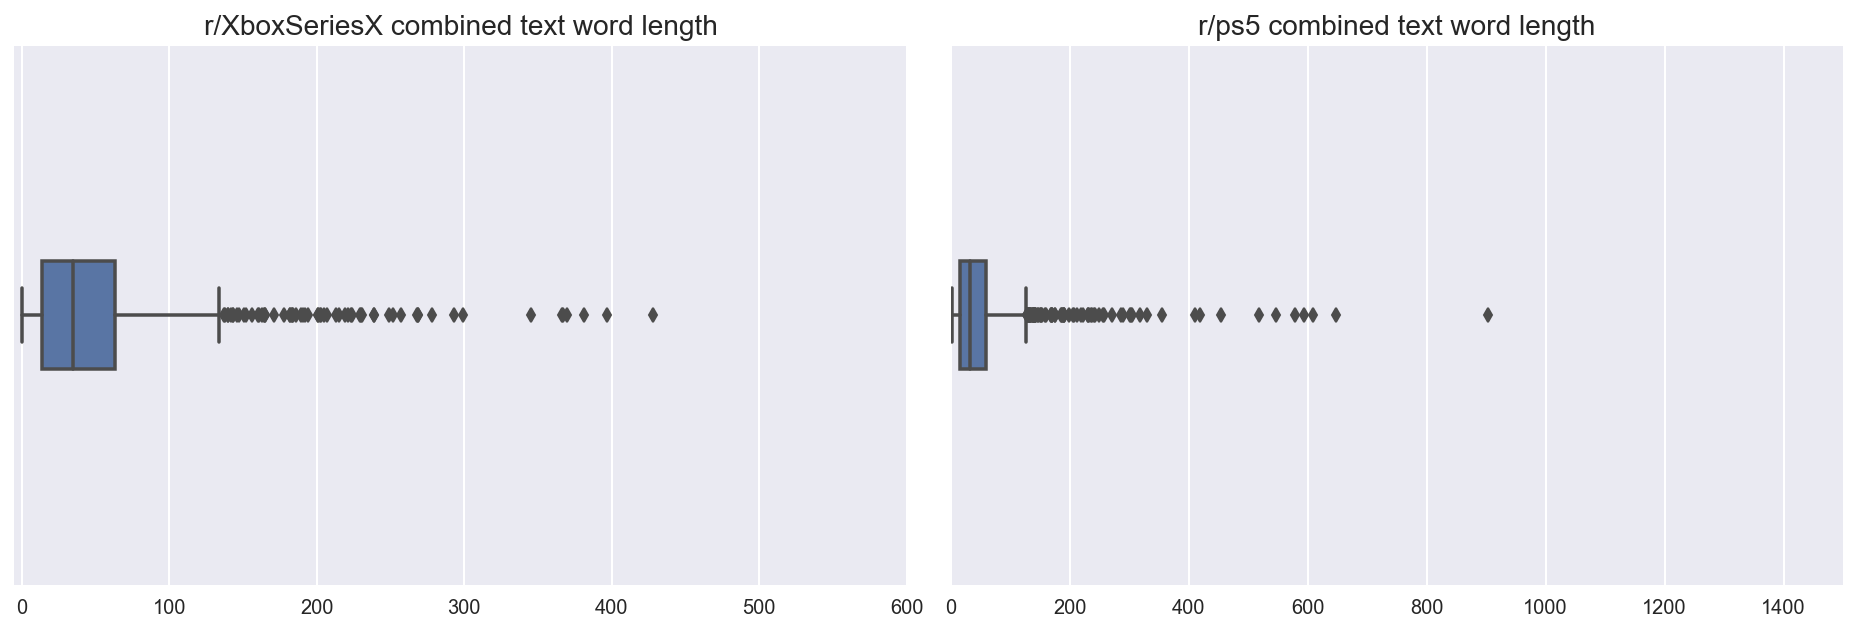

In [504]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 4.5))

sns.boxplot(df_xboxseriesx['word_count_combined_text'], ax = ax[0], width = 0.2)
ax[0].set_xlabel('')
ax[0].set_xlim(-5,600)
ax[0].set_title('r/XboxSeriesX combined text word length', fontsize=14)
sns.boxplot(df_ps5['word_count_combined_text'], ax = ax[1], width = 0.2)
ax[1].set_xlabel('')
ax[1].set_xlim(0,1500)
ax[1].set_title('r/ps5 combined text word length', fontsize=14)

plt.tight_layout()

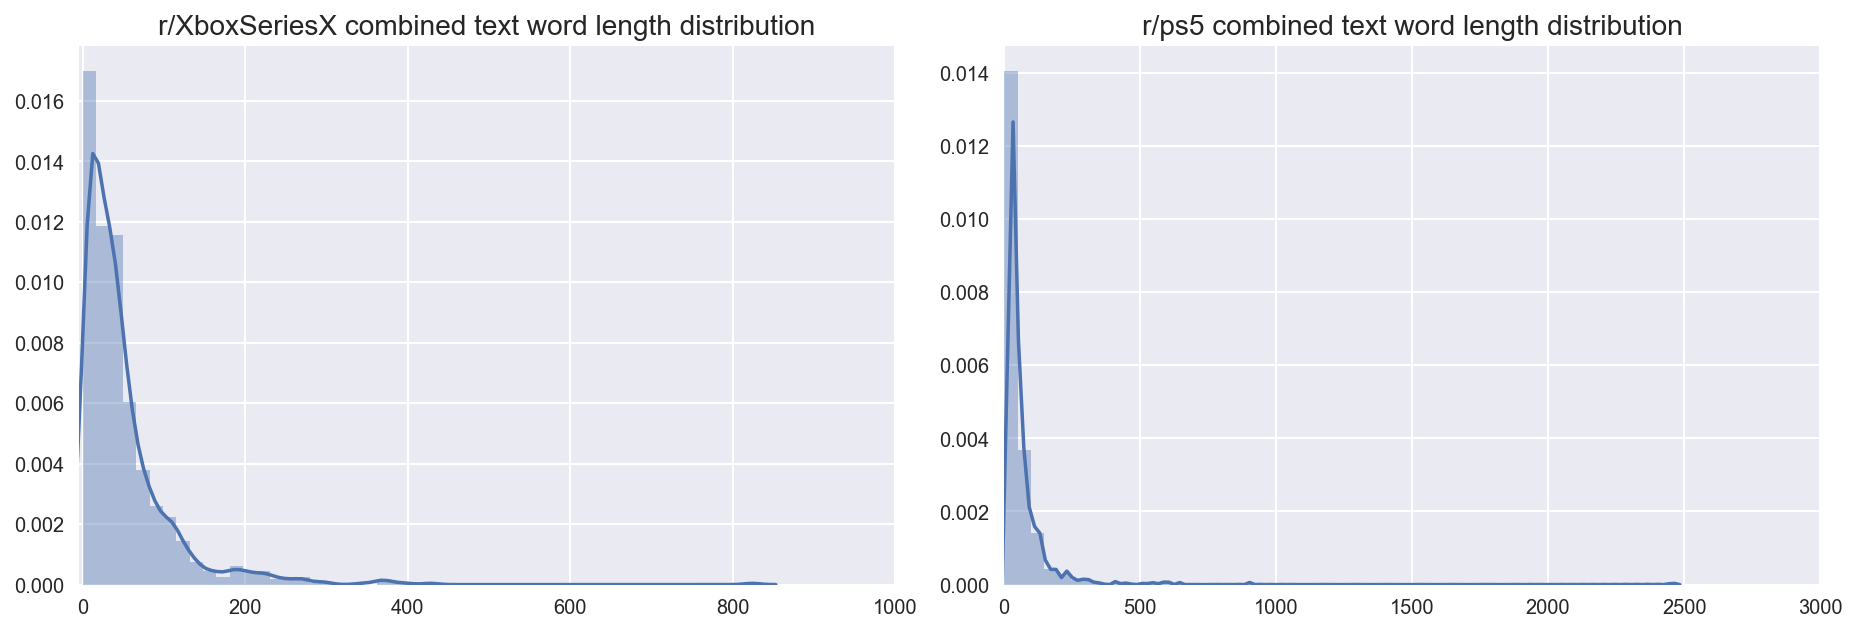

In [505]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 4.5))

sns.distplot(df_xboxseriesx['word_count_combined_text'], ax = ax[0])
ax[0].set_xlabel('')
ax[0].set_xlim(-5,1000)
ax[0].set_title('r/XboxSeriesX combined text word length distribution', fontsize=14)
sns.distplot(df_ps5['word_count_combined_text'], ax = ax[1])
ax[1].set_xlabel('')
ax[1].set_xlim(0,3000)
ax[1].set_title('r/ps5 combined text word length distribution', fontsize=14)


plt.tight_layout()

In [506]:
df_xboxseriesx.describe().T

count        mean         std   min    25%    50%  \
score                     976.0  105.720287  655.194955  0.00   1.00   3.00   
upvote_ratio              976.0    0.691168    0.215446  0.07   0.55   0.72   
num_comments              976.0   32.298156   75.386690  0.00   7.00  14.00   
word_count_combined_text  976.0   51.129098   61.424657  0.00  14.00  34.50   

                            75%      max  
score                     24.00  16579.0  
upvote_ratio               0.86      1.0  
num_comments              28.00   1332.0  
word_count_combined_text  63.00    824.0

In [507]:
df_ps5.describe().T

count        mean          std   min    25%    50%  \
score                     930.0  383.684946  1771.738726  0.00   0.00  16.00   
upvote_ratio              930.0    0.612333     0.252430  0.08   0.39   0.65   
num_comments              930.0  183.875269   958.777995  1.00  22.00  49.00   
word_count_combined_text  930.0   56.701075   109.160654  2.00  15.00  33.00   

                             75%      max  
score                     136.75  36541.0  
upvote_ratio                0.84      1.0  
num_comments              123.75  22198.0  
word_count_combined_text   60.00   2457.0

**Summary of word length comparison**
r/PS5 has 930 entries, while XboxSeriesX has 976 entries. PS5 readers tend to comment a lot more, with median at 49, maximum comments for a post is 22198 comments. XboxSeriesX at median number of post is 14, maiximum is 1332. This might not be relavant to our project, but it could be god to explore if later I were to perform sentiment analysis.



## Deep Dive into Content of Post
To explore the geninue content of the post for the 2 subreddits, more cleaning needs to be done to remove stop_words in order to have better visibility. Stop_words usually refers to the most common words in a language, usually have little meaning as they were used frequently.

In this section, I discovered what common words between the 2 subreddits. Most of the words are Stop words = 'english', which is needed to be removed to address outliers issue. 
After english stop words removal, many words of the same root were observed in this section, eg 'games', 'game'. By right these 2 words should be able to be combined as same word by stemming or lemmatization. Since both words appeared in both subreddits, I will proceed to perform 2nd round of stop_words removal by adding customizing stop_words. Stemming, and lemmatization will be perform at Preprocessing as per Rubric

In [508]:
# function to examine top 20 words in combined_text

def top_20_words(subreddit):
    cvec = CountVectorizer() # purposefully not to use stop_words here as it is already removed
    cvec.fit(subreddit['combined_text'])

    subreddit_cv = pd.DataFrame(cvec.transform(subreddit['combined_text']).todense(),columns=cvec.get_feature_names())

    subreddit_combined_text = subreddit_cv.sum(axis=0)
    subreddit_combined_text = subreddit_combined_text.sort_values(ascending = False).head(20)
    subreddit_combined_text = pd.DataFrame(subreddit_combined_text,columns = ['count'])
    
    return subreddit_combined_text

In [509]:
# Apply function to examine top 20 words is XboxSeriesX subreddit in combined_text
top_20_words(df_xboxseriesx).T.columns
# stop_words removed
# notice same root words like 'games', 'game' appeared in the top 20 list
# These words can be removed by stemming/lemmatization or even removed as customized stop_words if it appears in both
# subreddits

Index(['the', 'and', 'xbox', 'for', 'series', 'that', 'have', 'will', 'one',
       'games', 'with', 'this', 'you', 'but', 'game', 'just', 'they', 'was',
       'get', 'can'],
      dtype='object')

In [510]:
# Apply function to examine top 20 words is PS5 subreddit in combinedText
top_20_words(df_ps5).T.columns
# stop_words removed
# notice same root words like 'games', 'game' appeared in the top 20 list
# These words can be removed by stemming/lemmatization or even removed as customized stop_words if it appears in both
# subreddits

Index(['the', 'and', 'for', 'ps5', 'that', 'you', 'games', 'this', 'will',
       'with', 'but', 'game', 'have', 'are', 'ps4', 'they', 'what', 'not',
       'like', 'just'],
      dtype='object')

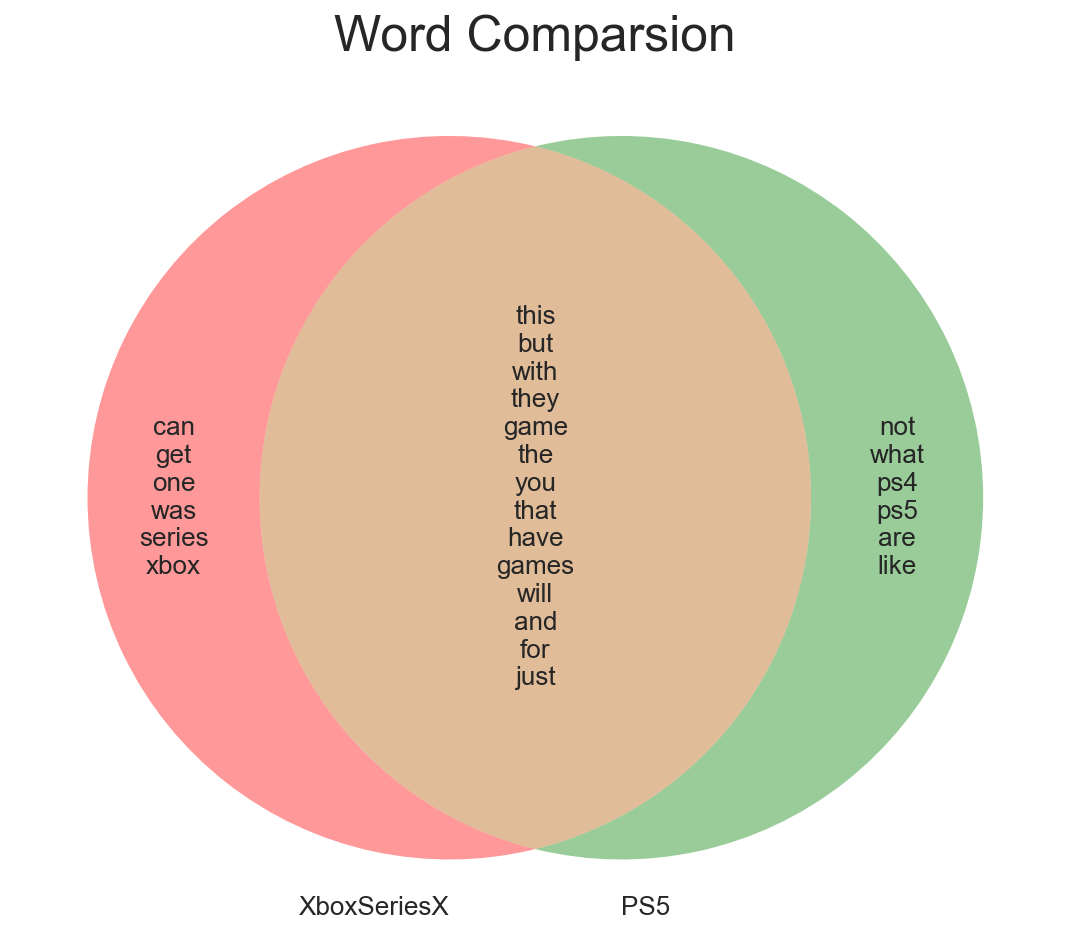

In [511]:
# venn diagram to see common words or root word to better visualization
plt.figure(figsize=(15,8))

# Convert top words to set for drawing venn diagram
top_words_set_xbox = set(top_20_words(df_xboxseriesx).index)
top_words_set_ps5 = set(top_20_words(df_ps5).index)

# title
plt.title('Word Comparsion',fontsize=25)

# plot venn diagram
v = venn2.venn2([top_words_set_xbox, top_words_set_ps5], ('XboxSeriesX', 'PS5'))

# set font size
for text in v.set_labels:
    text.set_fontsize(13)
for text in v.subset_labels:
    text.set_fontsize(13)

# labeling of words
v.get_label_by_id('100').set_text('\n'.join(top_words_set_xbox-top_words_set_ps5))
v.get_label_by_id('110').set_text('\n'.join(top_words_set_xbox&top_words_set_ps5))
v.get_label_by_id('010').set_text('\n'.join(top_words_set_ps5-top_words_set_xbox))

**Venn diagram findings: Cleaning needs to be done to remove stop_words='english'. Also, need to consider if customized stop_words(common words needs to be removed**\
Stop words = english removal to address outliers identification (Round 1)

In [512]:
# import stop_words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Hong
[nltk_data]     Yee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [513]:
print(stop_words)

{'wouldn', 'myself', 'that', 'between', 'weren', 'because', 'only', 'for', 'didn', 'whom', 'their', 'themselves', 'this', 'they', 'ours', 'm', 'the', 'not', 'your', 'before', 'ma', 'have', 'or', 'again', 'very', 'haven', 'these', 'some', 'aren', 'by', 'up', 'doesn', "haven't", 'd', 'are', "you've", 'where', 'be', 'at', 'same', 'on', 'itself', 'until', 'her', 'does', "wouldn't", 'ourselves', 'do', "you'll", 'ain', 'here', "you'd", 'hadn', 'couldn', 'were', 'hers', 'who', 'through', 'been', "that'll", "hasn't", 'don', 'other', 'more', "she's", "couldn't", 'just', 'wasn', 'off', 'further', 'theirs', 're', 'she', 'after', 'we', 'my', 'having', 'i', 'why', 'shan', 'out', 'so', "you're", 'am', 'needn', 'won', 'about', 'of', 'too', 'our', "doesn't", "wasn't", "mustn't", 'them', 'into', 'each', 't', 'was', 'has', 'few', 'being', 'both', 'nor', "don't", 'now', 'o', 'while', 'shouldn', "shouldn't", 'you', 'had', 'a', 'than', 'own', "aren't", 'yourself', 'as', 'did', 'mustn', 'there', 'but', 'll'

In [514]:
# apply stop_word removal to both subreddits
df_ps5['combined_text'] = df_ps5['combined_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_xboxseriesx['combined_text'] = df_xboxseriesx['combined_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

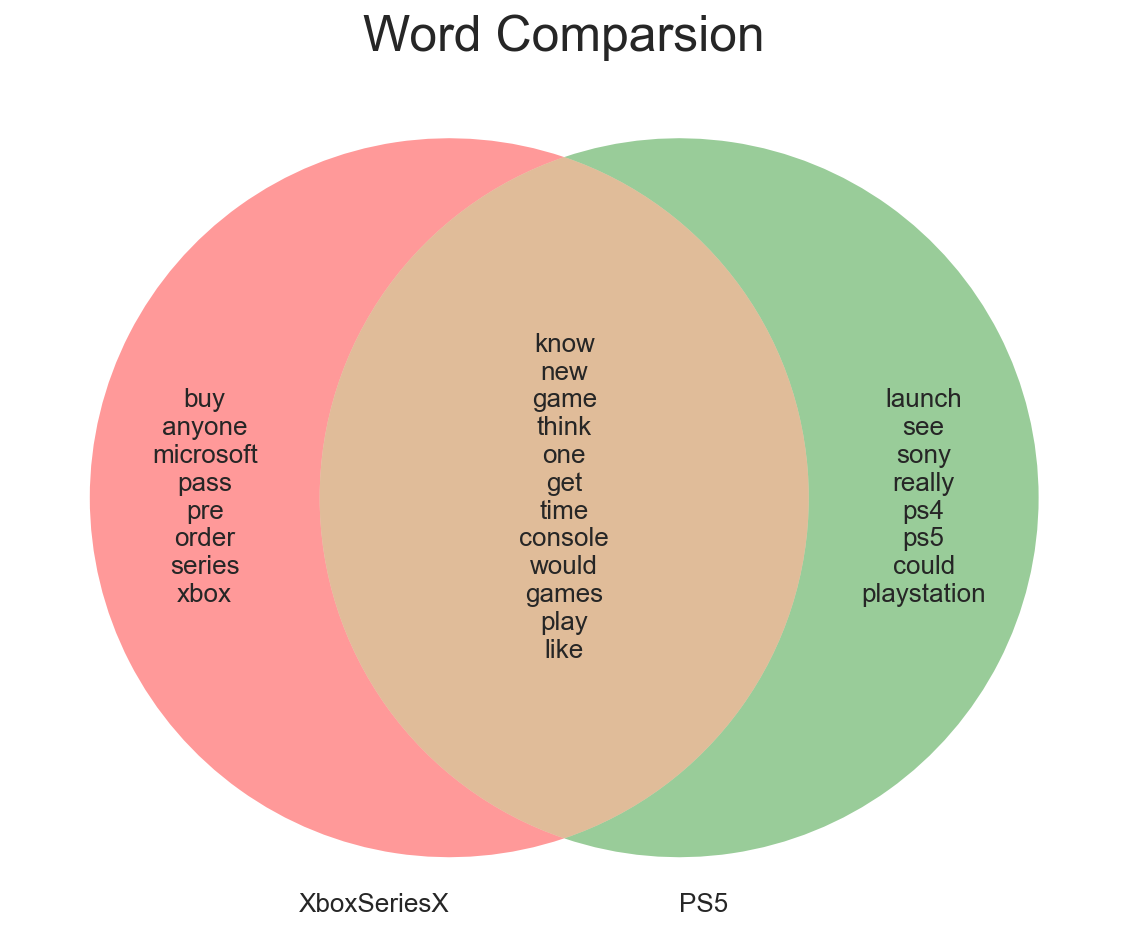

In [515]:
# venn diagram after stop words = "english" is applied
plt.figure(figsize=(15,8))

# Convert top words to set for drawing venn diagram
top_words_set_xbox = set(top_20_words(df_xboxseriesx).index)
top_words_set_ps5 = set(top_20_words(df_ps5).index)

# title
plt.title('Word Comparsion',fontsize=25)

# plot venn diagram
v = venn2.venn2([top_words_set_xbox, top_words_set_ps5], ('XboxSeriesX', 'PS5'))

# set font size
for text in v.set_labels:
    text.set_fontsize(13)
for text in v.subset_labels:
    text.set_fontsize(13)

# labeling of words
v.get_label_by_id('100').set_text('\n'.join(top_words_set_xbox-top_words_set_ps5))
v.get_label_by_id('110').set_text('\n'.join(top_words_set_xbox&top_words_set_ps5))
v.get_label_by_id('010').set_text('\n'.join(top_words_set_ps5-top_words_set_xbox))

**There is still considerable amount of common words between the 2 subreddit. Hence, proceed to perform 2nd round of cleaning (customized stop words)**

**5) Stop words removal to address outliers identification (Round 2). Based on the common words in the venn diagram above**

In [516]:
# Common words identified from the list above after first round of stop_words = 'english' removal
additional_stopwords = {'games','game','play','like','new','know','get','think','one'}
stop_words = stop_words.union(additional_stopwords)

In [517]:
# apply additional stop_words to both subreddits
df_ps5['combined_text'] = df_ps5['combined_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_xboxseriesx['combined_text'] = df_xboxseriesx['combined_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

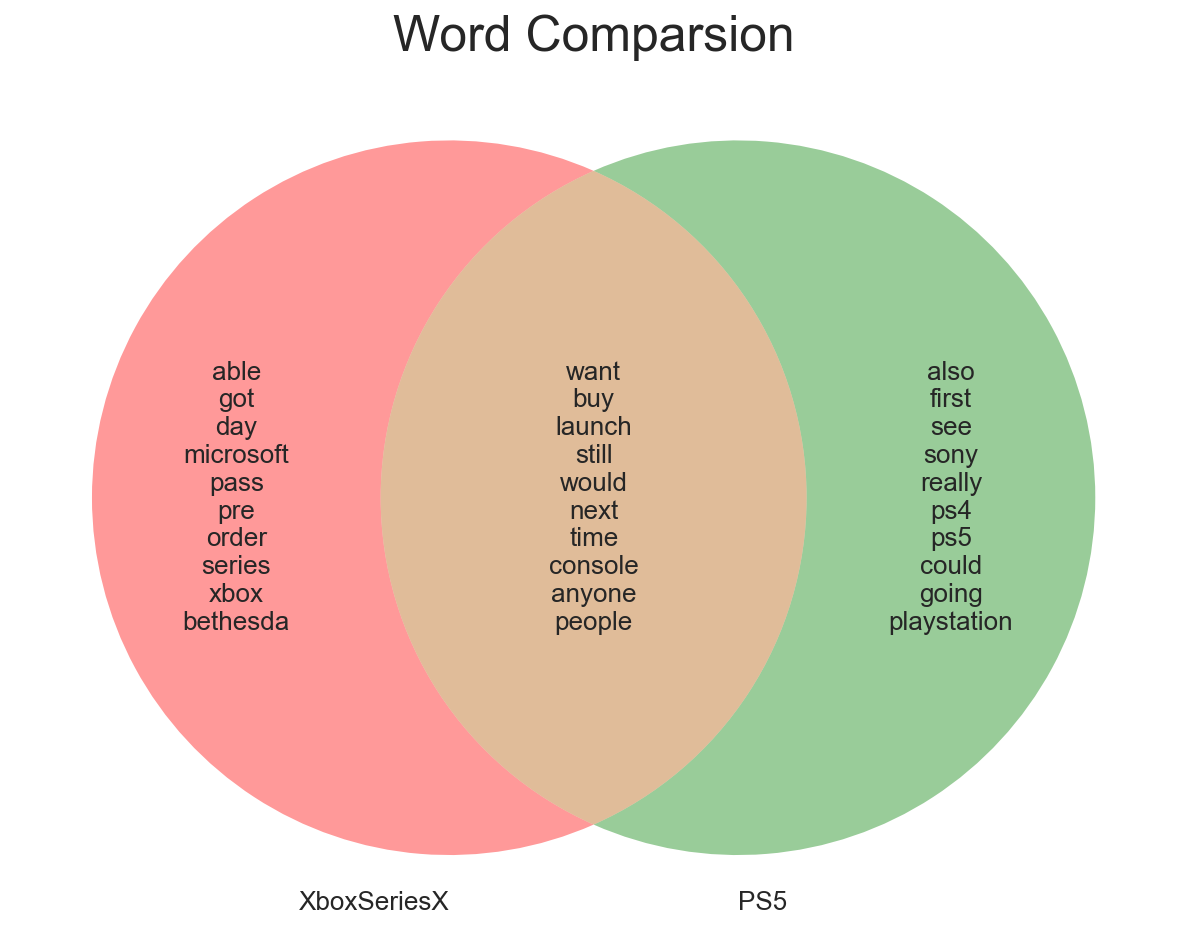

In [518]:
plt.figure(figsize=(15,8))

# Convert top words to set for drawing venn diagram
top_words_set_xbox = set(top_20_words(df_xboxseriesx).index)
top_words_set_ps5 = set(top_20_words(df_ps5).index)

# title
plt.title('Word Comparsion',fontsize=25)

# plot venn diagram
v = venn2.venn2([top_words_set_xbox, top_words_set_ps5], ('XboxSeriesX', 'PS5'))

# set font size
for text in v.set_labels:
    text.set_fontsize(13)
for text in v.subset_labels:
    text.set_fontsize(13)

# labeling of words
v.get_label_by_id('100').set_text('\n'.join(top_words_set_xbox-top_words_set_ps5))
v.get_label_by_id('110').set_text('\n'.join(top_words_set_xbox&top_words_set_ps5))
v.get_label_by_id('010').set_text('\n'.join(top_words_set_ps5-top_words_set_xbox))

**The top_20 words improved for both list after 2 rounds of stop_words removal. Common words were greatly reduced. Will stop with 2 rounds as over removing of stop_words will leads to losing training set that could be useful**

Summary of stop_words removal:
- Stop_words = 'english' was removed to address outliers issue. Notice words that have the same root eg 'games' and 'game' appeared in the top 100 word list. These words can be removed by stemming/lemmatization or removed as customized stop_words. Since they appear in both subreddits, I proceed to do a 2nd round of stop_words removal. Stemming and Lemmatization will be at Preprocessing.

In [519]:
# Output: saving xboxseriesx and ps5 after_cleaned dataframe posts to csv
df_ps5.to_csv('../data/ps5_posts_after_cleaned.csv', index = False)
df_xboxseriesx.to_csv('../data/df_xboxseriesx_posts_after_cleaned.csv', index = False)

**After removing the stop words, we can concentrate on exploring the content text eg Top words frequency for both subreddits and compare them, make word cloud for better visualizaion**

In [597]:
# Top words from PS5 title using Countvectorization

cvec = CountVectorizer(stop_words='english')
cvec.fit(df_ps5['combined_text'])

len_features = len(cvec.get_feature_names())
print("Total number of feature length for r/PS5 title is:", len_features)

df_ps5_cv = pd.DataFrame(cvec.transform(df_ps5['combined_text']).todense(),columns=cvec.get_feature_names())

top_ps5_40 = df_ps5_cv.sum(axis=0)
top_ps5_40 = top_ps5_40.sort_values(ascending = False).head(40)
top_ps5_40

Total number of feature length for r/PS5 title is: 4969


ps5            888
ps4            392
sony           320
console        212
launch         182
playstation    177
time           170
really         157
want           132
make           132
buy            126
people         125
going          122
version        120
day            119
gen            107
year           106
getting        103
soul           103
digital        103
look           102
need           101
thing          100
good            99
able            98
title           95
controller      93
plus            86
got             83
work            83
better          82
demon           81
man             79
use             75
edition         74
say             73
feature         73
lot             73
edit            70
way             70
dtype: int64

In [598]:
# Top words from XboxSeriesX title using Countvectorization
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_xboxseriesx['combined_text'])

len_features = len(cvec.get_feature_names())
print("Total number of feature length for r/XboxSeriesX title is:", len_features)

df_xboxseriesx_cv = pd.DataFrame(cvec.transform(df_xboxseriesx['combined_text']).todense(),columns=cvec.get_feature_names())

top_xboxseriesx_40 = df_xboxseriesx_cv.sum(axis=0)
top_xboxseriesx_40 = top_xboxseriesx_40.sort_values(ascending = False).head(40)
top_xboxseriesx_40

Total number of feature length for r/XboxSeriesX title is: 4259


xbox          1023
series         742
console        311
order          259
microsoft      239
pre            236
buy            187
pas            171
time           170
day            151
year           145
work           136
got            132
able           130
month          128
want           123
launch         120
people         119
bethesda       118
account        115
make           111
gen            107
getting        101
going          100
gamepass        98
store           98
controller      97
question        94
use             93
really          91
xsx             91
access          91
preorder        88
card            88
ps5             84
best            83
release         82
gold            81
studio          77
good            75
dtype: int64

**The 2 subreddits have a difference of more than 1000 words. With PS5 having more words**

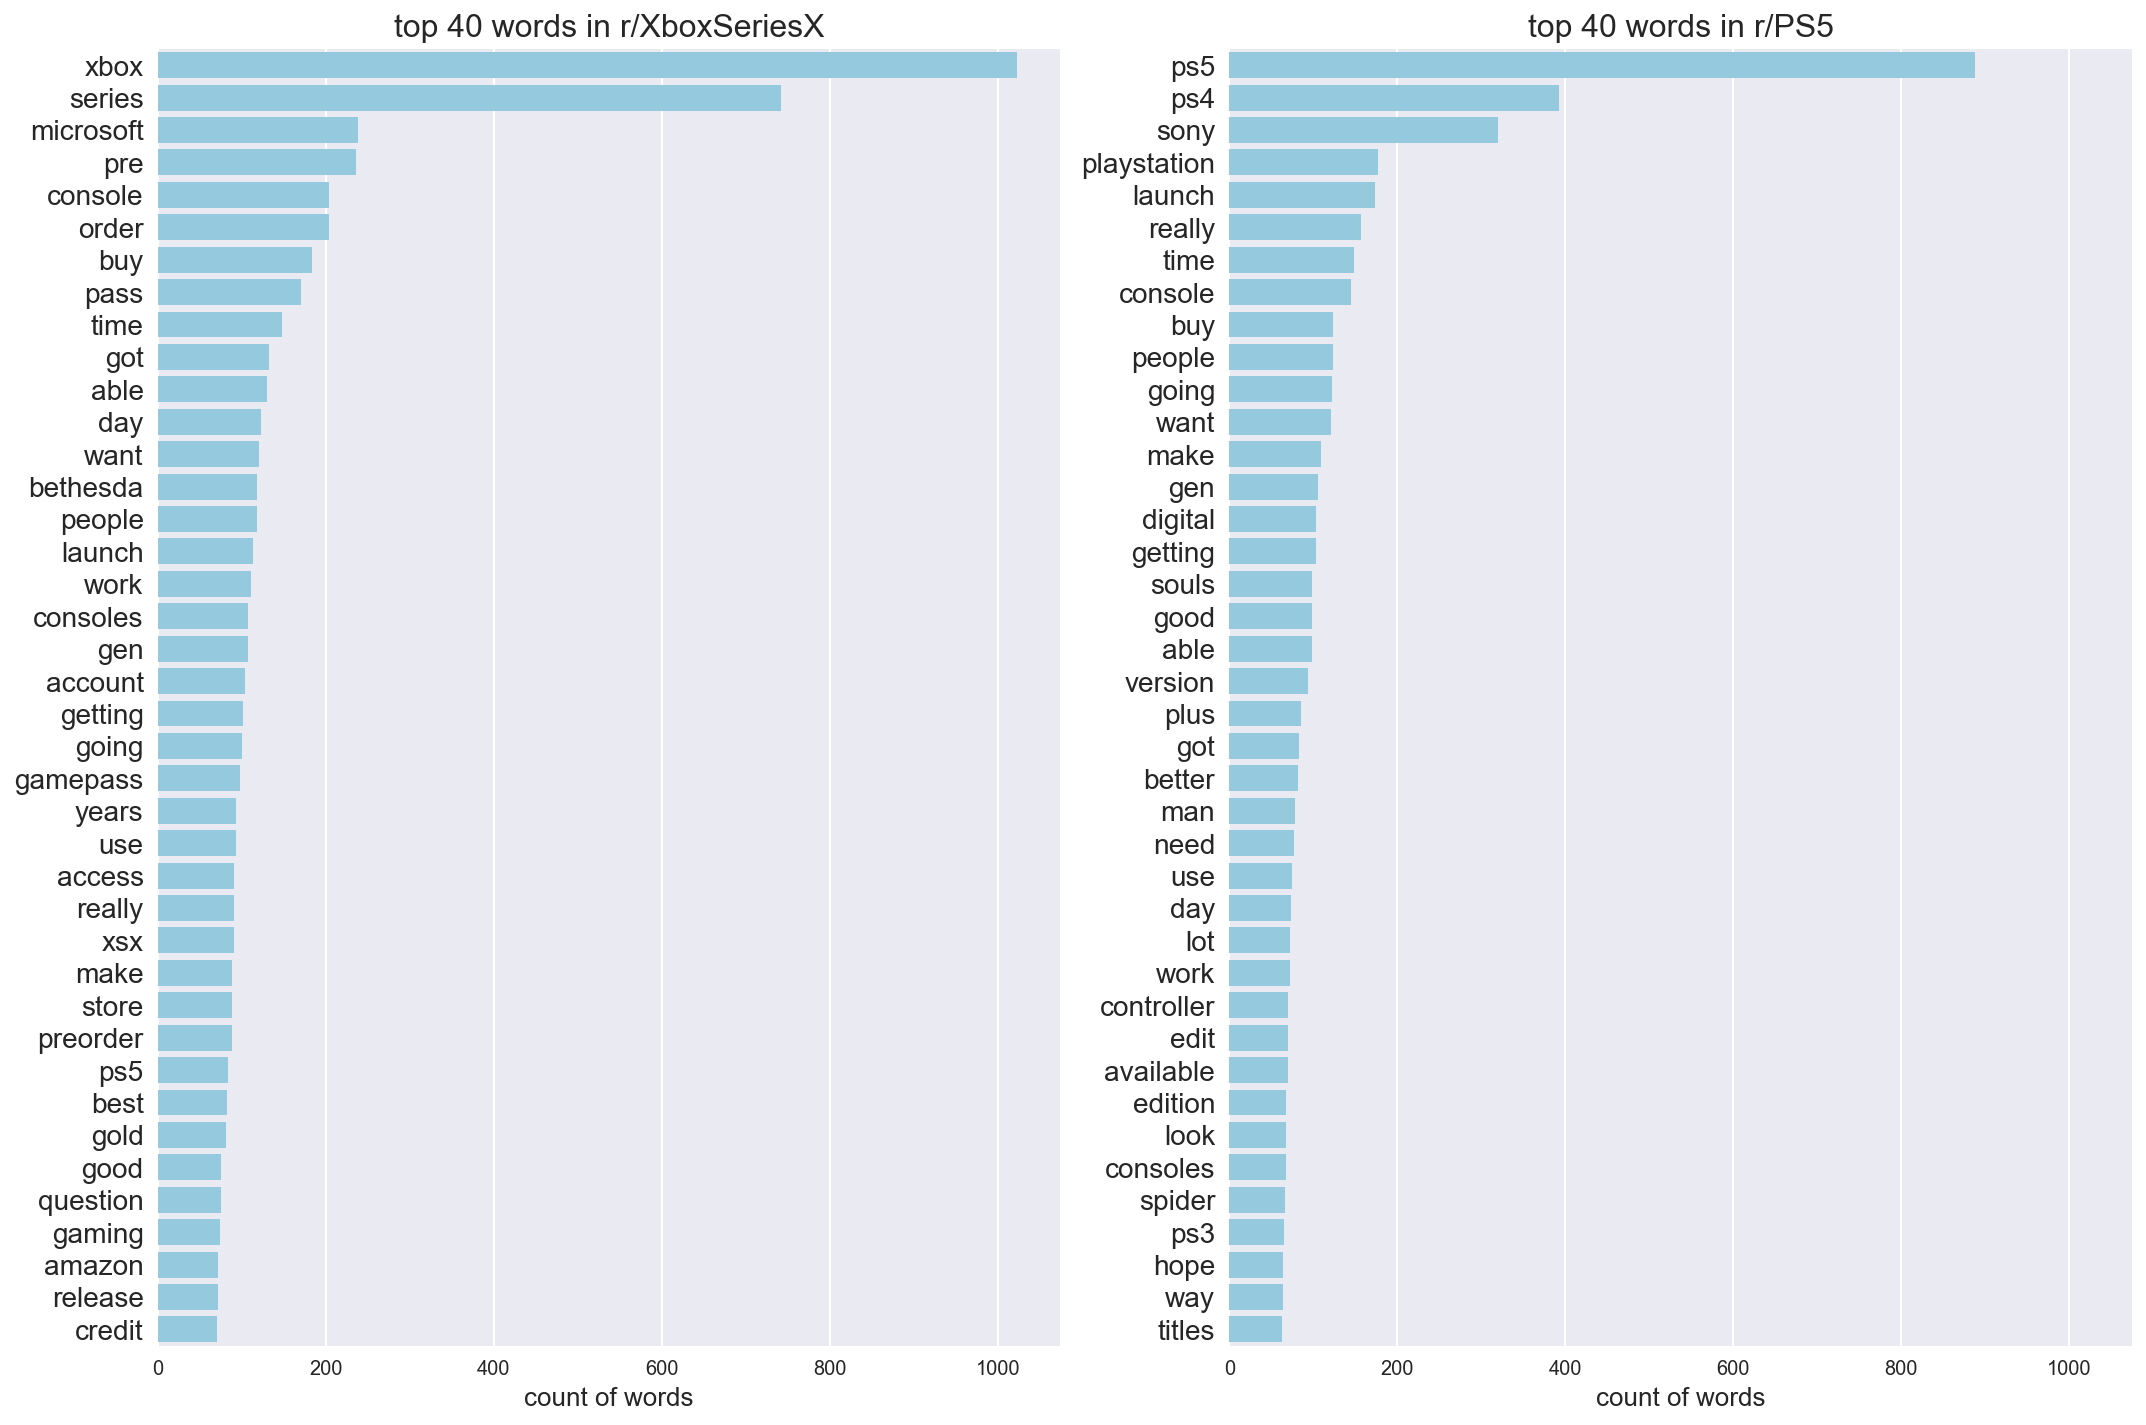

In [521]:
# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=top_xboxseriesx_40.index.values, x = top_xboxseriesx_40,color='skyblue',ax=ax[0])
ax[0].set_title('top 40 words in r/XboxSeriesX',fontsize=16)
ax[0].set_xlabel('count of words', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=top_ps5_40.index.values, x = top_ps5_40,color='skyblue',ax=ax[1])
ax[1].set_title('top 40 words in r/PS5',fontsize=16)
ax[1].set_xlabel('count of words', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

### Word Cloud Comparison
Common words for XboxSeriesX subreddit are:
- xbox, series, microsoft, pre

Common words for XboxSeriesX subreddit are:
- ps5, ps4, sony, playstation

These words will strike a reader at first glance and would indicate to readers at first glance what Trading subreddit is mostly about, as these words appear frequently in the Trading subreddit

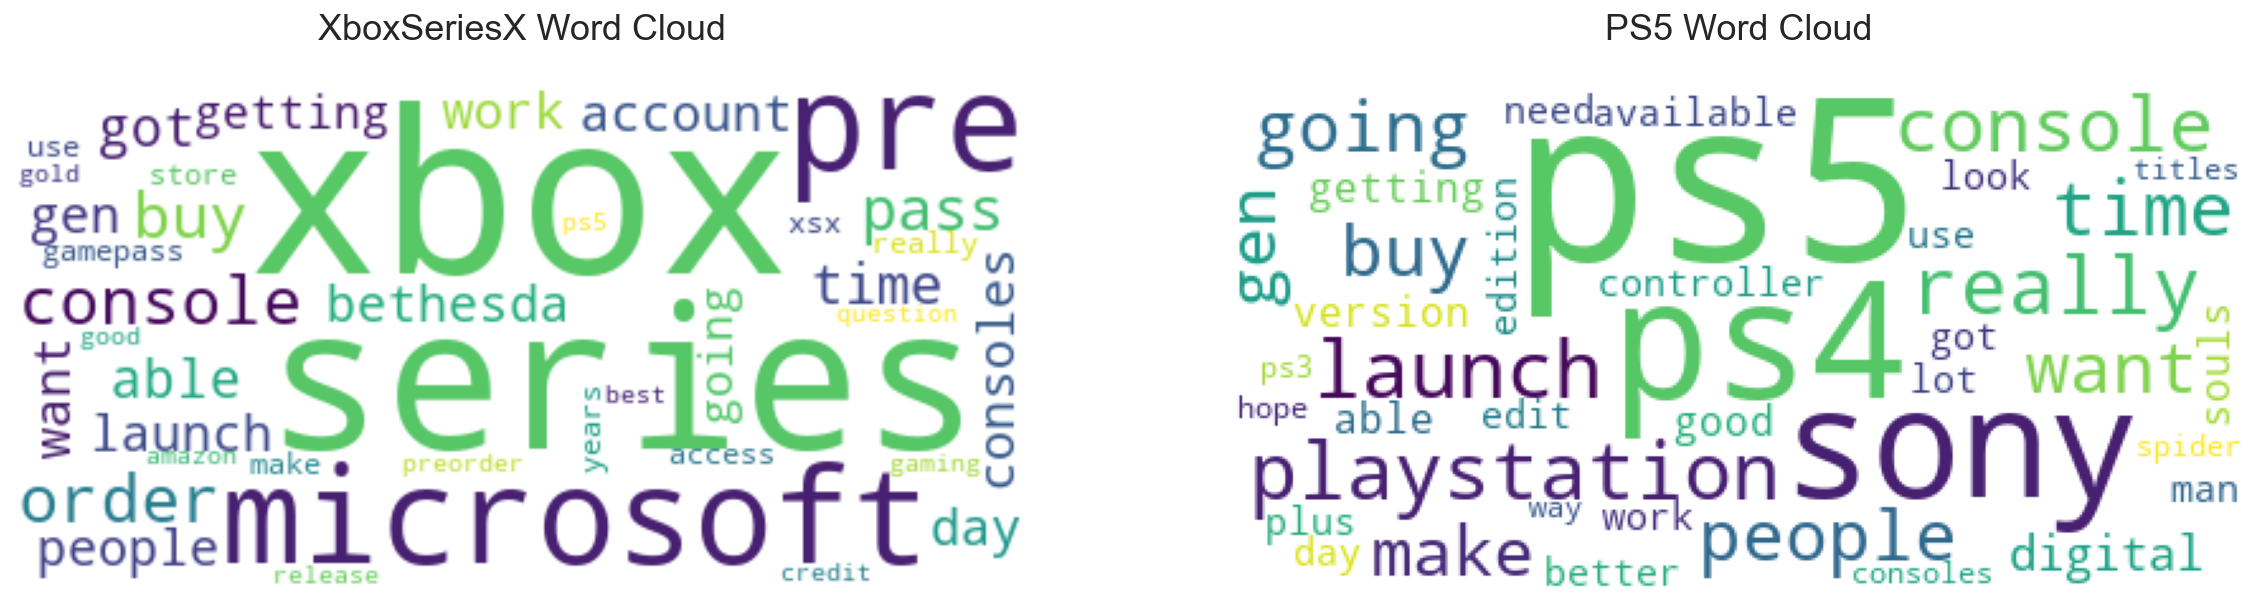

In [522]:
# wordcloud comparison for title

wc_ps5 = WordCloud(background_color="white", max_words=50, max_font_size=90, random_state=42)
wc_ps5.generate_from_frequencies(top_ps5_40)

wc_xboxseriesx = WordCloud(background_color="white", max_words=50, max_font_size=90, random_state=42)
wc_xboxseriesx.generate_from_frequencies(top_xboxseriesx_40)
              
# create coloring from image
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 20))

ax[0].imshow(wc_xboxseriesx, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('XboxSeriesX Word Cloud', pad = 24, fontsize=18)

ax[1].set_title('PS5 Word Cloud', pad = 24, fontsize=18)
ax[1].imshow(wc_ps5)
ax[1].axis("off");

### Summary Statistics

# Preprocessing

**Explore both Stemming and Lemmatization. Select 1 of them**

One of the reason I place Lemmatization/stemming at preprocessing instead of data cleaning is because i might not be able to decipher the stemmed words and will have difficulty to decide if it is insufficient cleaning or its after-stemmed, during EDA analysis. 

Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.

Difference?\
Stemming technique only looks at the form of the word whereas lemmatization technique looks at the meaning of the word. It means after applying lemmatization, we will always get a valid word.

**Try Stemming**

In [523]:
porter_stemmer = PorterStemmer()

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

In [524]:
df_xboxseriesx['combi_stem'] = df_xboxseriesx['combined_text'].apply(stem_sentences)
df_ps5['combi_stem'] = df_ps5['combined_text'].apply(stem_sentences)

In [525]:
df_ps5['combi_stem'].head()

0                                                                                                                              stop stop peopl ask question yessss use ps4 ps5 period
1                                                             playstat design studio microsoft design studio control isotop control similar servic soni also great servic ps5 control
2                                                                                                                abl download ps4 ps5 bought lot ps4 would hate loos ill decid upgrad
3                                                   connect ps4 extend storag hard drive ps5 access hard drive use extend storag ps4 ton possibl use devic ps5 without download stuff
4    playstat plu collect question come plu collect full come subscript portion buy someon work tri tell certain basic demo buy told make sens dumb wanna confirm full come subscript
Name: combi_stem, dtype: object

In [526]:
df_xboxseriesx['combi_stem'].head()

0                                                                                                                                                                                                                                                                                                                                random fan decid make awesom xgp trailer credit vincenzo fayez channel
1                                                                                                                                                                                                                                                                           taco bell deal avail countri pretti sure taco bell saudi arabia idk prize thing avail appreci help ye check googl say anyth
2                                                                                                state mous keyboard support xbox consol buy seri regardless mous keyboard support wonder current state mainli shooter p

**Try lemmatization**

In [527]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Hong
[nltk_data]     Yee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [528]:
def lemma(text):
    tokens = tokenizer.tokenize(str(text))
    lems = [lemmatizer.lemmatize(i) for i in tokens]
    
    return(" ".join(lems))

In [529]:
# Instantiate Tokenizer
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

df_xboxseriesx['combined_text'] = df_xboxseriesx['combined_text'].apply(lambda x: lemma(x))
df_ps5['combined_text'] = df_ps5['combined_text'].apply(lambda x: lemma(x))

In [530]:
df_xboxseriesx['combined_text'].head()

0                                                                                                                                                                                                                                                                                                                                                                              random fan decided make awesome xgp trailer credit vincenzo fayez channel
1                                                                                                                                                                                                                                                                                                         taco bell deal available country pretty sure taco bell saudi arabia idk prize thing available appreciated help yes checked google say anything
2                                                                                                                state

In [531]:
df_ps5['combined_text'].head(5)

0                                                                                                                                                           stop stop people asking question yes use ps4 ps5 period
1                                                                            playstation design studio microsoft design studio controller isotope controller similar service sony also great service ps5 controller
2                                                                                                                                          able download ps4 ps5 bought lot ps4 would hate loose ill decide upgrade
3                                                                       connect ps4 extended storage hard drive ps5 access hard drive using extended storage ps4 ton possible use device ps5 without download stuff
4    playstation plus collection question coming plus collection full come subscription portion buy someone work trying tell certain basically demo buy 

**Summary of Stemming or Lemmatization preprocessing?**
The best way to decide whether to use stemming or lemmatization is to run both data through the modeling process and see which method produces better variance, R2 and confusion matrix scoring. Due to time constraint, this option was not be able to be performed. Generally, lemmatization is recommended for projects where the meaning of the text language is important to the success of the project. For this project, consideration of the text language meaning is not needed. However, I would prefer to use lemmatization because it is not as brutal as stemming. Stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech.

In [532]:
df_xboxseriesx.head()

score  upvote_ratio  num_comments  \
0     13          0.88             7   
1      0          0.25             1   
2      2          1.00             4   
3      0          0.09             3   
4      1          1.00             2   

                                                                                                                                                                                                                                                                                                                                                                                                                                         combined_text  \
0                                                                                                                                                                                                                                                                                                                                                                            random fan decided make awesome xgp trailer credit vincenzo fayez channel   
1                                                                                                                                                                                                                                                                                                       taco bell deal available country pretty sure taco bell saudi arabia idk prize thing available appreciated help yes checked google say anything   
2                                                                                                              state mouse keyboard support xbox console buying series regardless mouse keyboard support wondering current state mainly shooter playing console controller feel drunk incredibly slow inaccurate understand support mouse keyboard single player true shooter really care multiplayer anymore would title doom mouse keyboard possible   
3                                                                                                                                                                                                                                                                                                                                                                                    anyone posted yet amazon release date halo infinite december 31st   
4  upgrade series price range two real option vizio tcl series inch vizio sold tcl 1440p interested since seems realistically afford panel however seems tcl blooming issue around text every video ive seen black crush insanely bad anyone experience tcl blooming black crush really bad youtube video exaggerating bad comparison vizio doesnt seem crush black video ive watched really want frame multiplayer black crush seems beyond noticable   

   word_count_combined_text  \
0                        12   
1                        31   
2                        75   
3                        18   
4                       105   

                                                                                                                                                                                                                                                                                                                                                                                           combi_stem  
0                                                                                                                                                                                                                                                                                                                              random fan decid make awesom xgp trailer credit vincenzo fayez channel  
1                                                                                                                                         

In [533]:
df_ps5.head()

score  upvote_ratio  num_comments  \
0      1          0.67             9   
1      3          1.00             1   
2      0          0.17             6   
3      0          0.33             8   
4      0          0.29             7   

                                                                                                                                                                                                    combined_text  \
0                                                                                                                                                         stop stop people asking question yes use ps4 ps5 period   
1                                                                          playstation design studio microsoft design studio controller isotope controller similar service sony also great service ps5 controller   
2                                                                                                                                        able download ps4 ps5 bought lot ps4 would hate loose ill decide upgrade   
3                                                                     connect ps4 extended storage hard drive ps5 access hard drive using extended storage ps4 ton possible use device ps5 without download stuff   
4  playstation plus collection question coming plus collection full come subscription portion buy someone work trying tell certain basically demo buy told make sense dumb wanna confirm full coming subscription   

   word_count_combined_text  \
0                        23   
1                        29   
2                        19   
3                        41   
4                        67   

                                                                                                                                                                         combi_stem  
0                                                                                                                            stop stop peopl ask question yessss use ps4 ps5 period  
1                                                           playstat design studio microsoft design studio control isotop control similar servic soni also great servic ps5 control  
2                                                                                                              abl download ps4 ps5 bought lot ps4 would hate loos ill decid upgrad  
3                                                 connect ps4 extend storag hard drive ps5 access hard drive use extend storag ps4 ton possibl use devic ps5 without download stuff  
4  playstat plu collect question come plu collect full come subscript portion buy someon work tri tell certain basic demo buy told make sens dumb wanna confirm full come subscript

In [534]:
# Create a binary column for each subreddit. df_xboxseriesx = 1, df_ps5 = 2
# One hot encoding

df_ps5['is_xbox'] = 0
df_xboxseriesx['is_xbox'] = 1

In [535]:
df_ps5.columns

Index(['score', 'upvote_ratio', 'num_comments', 'combined_text',
       'word_count_combined_text', 'combi_stem', 'is_xbox'],
      dtype='object')

In [536]:
df_xboxseriesx.columns

Index(['score', 'upvote_ratio', 'num_comments', 'combined_text',
       'word_count_combined_text', 'combi_stem', 'is_xbox'],
      dtype='object')

In [537]:
# Concatenating dataframes 
ps5_xboxseriesx = pd.concat([df_ps5, df_xboxseriesx])

In [538]:
# to prepare a dataframe for sentiment analysis later
ps5_xboxseriesx_sentiment = ps5_xboxseriesx[['combined_text', 'is_xbox', 'score', 'num_comments', 'upvote_ratio']]

In [539]:
# For now, i will only keep title(strong unique words for differentiation found during EDA), combined_text, is_ps5 one-hot
# encoding column.
# Reason being selftext has blanks and poor uniques words during EDA
# 'selftext' has many blank data

ps5_xboxseriesx = ps5_xboxseriesx[['combined_text', 'is_xbox']]

In [540]:
ps5_xboxseriesx.shape

(1906, 2)

In [541]:
ps5_xboxseriesx_sentiment.shape

(1906, 5)

In [542]:
# reset index
ps5_xboxseriesx.reset_index(drop=True).head()

combined_text  \
0                                                                                                                                                         stop stop people asking question yes use ps4 ps5 period   
1                                                                          playstation design studio microsoft design studio controller isotope controller similar service sony also great service ps5 controller   
2                                                                                                                                        able download ps4 ps5 bought lot ps4 would hate loose ill decide upgrade   
3                                                                     connect ps4 extended storage hard drive ps5 access hard drive using extended storage ps4 ton possible use device ps5 without download stuff   
4  playstation plus collection question coming plus collection full come subscription portion buy someone work trying tell certain basically demo buy told make sense dumb wanna confirm full coming subscription   

   is_xbox  
0        0  
1        0  
2        0  
3        0  
4        0

In [543]:
ps5_xboxseriesx_sentiment.reset_index(drop=True).head()

combined_text  \
0                                                                                                                                                         stop stop people asking question yes use ps4 ps5 period   
1                                                                          playstation design studio microsoft design studio controller isotope controller similar service sony also great service ps5 controller   
2                                                                                                                                        able download ps4 ps5 bought lot ps4 would hate loose ill decide upgrade   
3                                                                     connect ps4 extended storage hard drive ps5 access hard drive using extended storage ps4 ton possible use device ps5 without download stuff   
4  playstation plus collection question coming plus collection full come subscription portion buy someone work trying tell certain basically demo buy told make sense dumb wanna confirm full coming subscription   

   is_xbox  score  num_comments  upvote_ratio  
0        0      1             9          0.67  
1        0      3             1          1.00  
2        0      0             6          0.17  
3        0      0             8          0.33  
4        0      0             7          0.29

In [544]:
ps5_xboxseriesx.isnull().sum()

combined_text    0
is_xbox          0
dtype: int64

ps5_xboxseriesx_sentiment.isnull().sum()

In [545]:
# Output: combined processed dataframe posts to csv
ps5_xboxseriesx.to_csv('../data/combined_preprocessed.csv', index = False)

## Create Feature Matrix (X =combined_text) and Target (y subreddit class=xbox)

In [546]:


# X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,test_size=0.2,stratify=y,random_state=3050)
# # the test set(20%) in this case consist of unseen test data to use it to test our final model

In [547]:
# # check train and test data

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [548]:
# from the test set, we further split into half

# X1_train,X1_val,y1_train,y1_val = train_test_split(X_train,y_train,train_size=0.75,test_size=0.25,stratify=y,random_state=3050)

In [550]:
# create X (feature matrix(for combined_text)) and y (target is xbox)

X = ps5_xboxseriesx['combined_text']
y = ps5_xboxseriesx['is_xbox']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train) # 0.25 x 0.8 = 0.2

In [552]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

# X_train, y_train will be used to train my models
# X_test, y_test will be used to test the models
# X_val, y_val will be used as unseen data to test the final selected model

(1143,)
(1143,)
(382,)
(382,)
(381,)
(381,)


## Modelling
**Zero Rule Algorithm to obtain baseline**\
ZeroR is the simplest classification method which relies on the target and ignores all predictors. ZeroR classifier simply predicts the majority category (class). Although there is no predictability power in ZeroR, it is useful for determining a baseline performance as a benchmark for other classification methods.

In [559]:
print("Accuracy of the baseline using Zero Rule Algorithm is") 
y_test.value_counts(normalize=True)

Accuracy of the baseline using Zero Rule Algorithm is


1    0.513089
0    0.486911
Name: is_xbox, dtype: float64

## Models by Pipeline Naive Bayes with CountVectorizer

In [560]:
pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

params_nb_cvec = {
    'cvec__max_features': [100, 500, 1000, 2000, 3000, 4000, 5000], 
    'cvec__ngram_range':[(1, 1), (1, 2), (1, 3)],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
}

gs_nb_cvec = GridSearchCV(pipe_nb_cvec, 
                        param_grid=params_nb_cvec,
                        cv=5,
                        n_jobs=2,
                        verbose=1)
    
gs_nb_cvec.fit(X_train, y_train)

print(f'GridSearch Best Params:{gs_nb_cvec.best_params_}')
print('Train Score:', gs_nb_cvec.score(X_train, y_train))
print('Test Score:', gs_nb_cvec.score(X_test, y_test))

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   20.3s
[Parallel(n_jobs=2)]: Done 420 out of 420 | elapsed:   38.2s finished


GridSearch Best Params:{'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
Train Score: 0.9361329833770778
Test Score: 0.8769633507853403


In [561]:
def conf_matrix(model, X_test, y_test):
    y_hat = model.predict(X_test) 
    # get confusion matrix data
    cm = confusion_matrix(y_test, y_hat)  
    # extract elements of confusion matrix
    tn, fp, fn, tp = cm.ravel()        
    
    # Convert Confusion Matrix to DataFrame
    df_cm = pd.DataFrame(cm, columns=['pred negative', 'pred positive'], index=['actual_negative', 'actual positive'])
    return df_cm
    
def conf_matrix_metrics(model, X_test, y_test):
    y_hat = model.predict(X_test) 
    cm = confusion_matrix(y_test, y_hat)  
    tn, fp, fn, tp = cm.ravel()           
    
    #calculate metrics 
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    sensitivity = tp / (tp + fn)
    specificity = tn/ (tn + fp)
    precision = tp /(tp + fp)
    
    return {'accuracy': np.round(accuracy,3),
            'sensitivity': np.round(sensitivity,3),
            'specificity': np.round(specificity,3),
            'precision': np.round(precision,3)}

print(conf_matrix(gs_nb_cvec, X_test, y_test))
conf_matrix_metrics(gs_nb_cvec, X_test, y_test)

                 pred negative  pred positive
actual_negative            161             25
actual positive             22            174


{'accuracy': 0.877,
 'sensitivity': 0.888,
 'specificity': 0.866,
 'precision': 0.874}

## Models by Pipeline to finetune Naive Bayes with TfidfVectorizer
Common words are penalized.
Rare words have more influence.

In [562]:
pipe_nb_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

params_nb_tf = {
    'tf__max_features': [1000, 2000, 3000, 4000, 5000], 
    'tf__ngram_range':  [(1, 1), (1, 2), (1, 3)],
}

gs_nb_tf = GridSearchCV(pipe_nb_cvec, 
                        param_grid=params_nb_cvec,
                        cv=5,
                        n_jobs=2,
                        verbose=1)
    
gs_nb_tf.fit(X_train, y_train)

print(f'GridSearch Best Params:{gs_nb_tf.best_params_}')
print('Train Score:', gs_nb_tf.score(X_train, y_train))
print('Test Score:', gs_nb_tf.score(X_test, y_test))

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   35.5s
[Parallel(n_jobs=2)]: Done 420 out of 420 | elapsed:   38.4s finished


GridSearch Best Params:{'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
Train Score: 0.9361329833770778
Test Score: 0.8769633507853403


In [563]:
print(conf_matrix(gs_nb_tf, X_test, y_test))
conf_matrix_metrics(gs_nb_tf, X_test, y_test)

                 pred negative  pred positive
actual_negative            161             25
actual positive             22            174


{'accuracy': 0.877,
 'sensitivity': 0.888,
 'specificity': 0.866,
 'precision': 0.874}

## Logistic Regression Modeling with TfidfVectorizer

In [564]:
pipe_lr_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

params_lr_tf = {
    'tf__max_features': [1000, 2000, 3000, 4000], 
    'tf__ngram_range':  [(1, 1), (1, 2), (1, 3)], 
    'lr__penalty':      ['l2', 'l1'],
    'lr__C':            [.5, .01, 1],
    'lr__random_state': [42] 
}
gs_lr_tf = GridSearchCV(pipe_lr_tf, 
                        param_grid=params_lr_tf,
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_lr_tf.fit(X_train, y_train)

print(f'GridSearch Best Params: {gs_lr_tf.best_params_}')
print('Train Score:', gs_lr_tf.score(X_train, y_train))
print('Test Score:', gs_lr_tf.score(X_test, y_test))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   34.6s finished


GridSearch Best Params: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__random_state': 42, 'tf__max_features': 4000, 'tf__ngram_range': (1, 3)}
Train Score: 0.9755030621172354
Test Score: 0.887434554973822


In [565]:
print(conf_matrix(gs_lr_tf, X_test, y_test))
conf_matrix_metrics(gs_lr_tf, X_test, y_test)

                 pred negative  pred positive
actual_negative            169             17
actual positive             26            170


{'accuracy': 0.887,
 'sensitivity': 0.867,
 'specificity': 0.909,
 'precision': 0.909}

## Logistic Regression Modeling with CountVectorizer

In [566]:
pipe_lr_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

params_lr_cvec = {
    'cvec__stop_words': [None, 'english'],
    'cvec__max_features': [100, 500, 1000, 2000, 3000, 4000, 5000], 
    'cvec__ngram_range':[(1, 1), (1, 2), (1, 3)],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'lr__penalty':      ['l2', 'l1'],
    'lr__C':            [.5, .01, 1],
    'lr__random_state': [42] 
}
gs_lr_cvec = GridSearchCV(pipe_lr_cvec, 
                        param_grid=params_lr_cvec,
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_lr_cvec.fit(X_train, y_train)

print(f'GridSearch Best Params: {gs_lr_cvec.best_params_}')
print('Train Score:', gs_lr_cvec.score(X_train, y_train))
print('Test Score:', gs_lr_cvec.score(X_test, y_test))

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   30.0s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 1588 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 2488 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done 3588 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done 4888 tasks      | elapsed:  7.0min


GridSearch Best Params: {'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__random_state': 42}
Train Score: 0.9081364829396326
Test Score: 0.8900523560209425


[Parallel(n_jobs=2)]: Done 5040 out of 5040 | elapsed:  7.3min finished


In [567]:
print(conf_matrix(gs_lr_cvec, X_test, y_test))
conf_matrix_metrics(gs_lr_cvec, X_test, y_test)

                 pred negative  pred positive
actual_negative            175             11
actual positive             31            165


{'accuracy': 0.89,
 'sensitivity': 0.842,
 'specificity': 0.941,
 'precision': 0.938}

- The best model is GridSearch Best Params: {'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__random_state': 42}.
- It has the least difference in train and test score, < 1%

Apply best model parameters using unseen data

## Summary of models performance

In [568]:
gs_lr_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 1000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'lr__C': 0.01,
 'lr__penalty': 'l2',
 'lr__random_state': 42}

In [577]:
final_lr_cvec = Pipeline([
    
    ('cvec', CountVectorizer(max_df= 0.9,
         max_features= 1000,
         min_df= 2,
         ngram_range= (1, 1),
         stop_words= None)),
     
     ('lr', LogisticRegression(C= 0.01, penalty= 'l2', random_state= 42))

     ])

In [581]:
final_lr_cvec.fit(X_train,y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=1000, min_df=2)),
                ('lr', LogisticRegression(C=0.01, random_state=42))])

In [582]:
final_lr_cvec.score(X_train,y_train)

0.9081364829396326

In [583]:
final_lr_cvec.score(X_test,y_test)

0.8900523560209425

In [584]:
a

0.884514435695538

In [588]:
pred = final_lr_cvec.predict(X_val)

In [591]:

# Making a dataframe with test data, which contains final_posts, actual class value, predicted class value, and predict probability

results = pd.DataFrame(X_val, columns=['combined_text']) # making a dataframe on one column known as final_posts
results['actual'] = y_val# add 'actual' column
results['predictions'] = pred
results['predict_proba'] = [i[1] for i in final_lr_cvec.predict_proba(X_val)]
results.shape

(381, 4)

In [592]:
results

combined_text  \
587                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    would hurt ps5 kept slanted would harm device let stay slanted cube jpg quite literally anywhere else place device yet   
899                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

## Model Evaluation

In [589]:
# Generate a confusion matrix.
cm = confusion_matrix(y_val, pred)
# convert into dataframe for better view
df_cm = pd.DataFrame(cm, columns=['pred negative', 'pred positive'], index=['actual_negative', 'actual positive'])
print("---------- This is the confusion matrix --------------")
print(df_cm)
print("------------------------------------------------------")
print('')

# assign terms for each confusion matrix parameter
tn, fp, fn, tp = confusion_matrix(y_val, pred).ravel()

# print out the scores
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print('')

# look at the scores of the parameters
accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
print('')

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))

---------- This is the confusion matrix --------------
                 pred negative  pred positive
actual_negative            179              7
actual positive             37            158
------------------------------------------------------

True Negatives: 179
False Positives: 7
False Negatives: 37
True Positives: 158


Accuracy: 0.885
Sensitivity: 0.81
Specificity: 0.962
Precision: 0.958


In [593]:
roc_auc_score(results['actual'], results['predict_proba'] )

NameError: name 'roc_auc_score' is not defined

## Conclusions and Recommendations

**Data Collection**
- Webscraping 2 subreddits using looping function and request. 976 r/XboxSeriesX and 930 r/PS5 unique posts were downloaded. 
- Title, selftext were the most important information extracted from this webscraping task and were used in my classification model.
- A looping function is used to automatically send request, download json files, convert to dataframe, extract only useful columns, remove duplicates, set appropriate random time sleep between 2 ~ 6 sec. Total process time is less than 4min/subreddit.

**Data Cleaning**
- Missing selftext is imputed with title after a combined_text column is created.
- Stop_words = 'english' and Customized stop_words consist of overlapping words, were removed from both subreddits post as outliers.
- 2 rounds of text content cleaning using regular expression. Remove standalone numbers but keep numbers connected with alphabets to preserve ps4, ps5. Changed text to lowercase, removed punctuations, emojis, hyperlinks, special characters, slash, \n etc.
- Examined number of words and comments to see any interesting findings that can contribute building my model. No interesting finding found.
- Examined the top frequent words in r/PS5 and r/XboxSeries. Top words in r/PS5 is 'PS4', 'PS5', 'Sony', 'playstation', 'launch' For r/XboxSeriesX, most frequent words are 'xbox', 'series', 'microsoft', 'pre', 'console'. They are mainly product names and names of manufacturers'
- 'launch', 'console' appeared as overlapped words across both subreddit.
- These unique words can be used to train my classification model. Top words for each subreddit is also identified to differentiate the them for classifying a post with missing label.

**Preprocessing and Modeling**
- Stemming and Lemmatization is explored. Lemmatizing is chosen. It was prefer because it it consider the language of the text, though it is not really important for this project.
- Data was split into 3 dataset. Training set is 60%, test set is 20% and unseen dataset is 20%. Training dataset is used to train model, and then test using test dataset. Unseen dataset will be used to evaluate the best selected model.
- Baseline score is obtained using ZeroR method, which is to count the % of positive class.
- 2 by 2 models - applied CountVectorizer and TF-IDF to each Naive Bayes and Logistic regression, ran with pipeline and gridsearch to evaluate performance of various hyperparameters. 